# Extracting value from the payment notes

In [27]:
import pandas as pd
import numpy as np
import psycopg2
import pymongo
import json
import datetime
import pickle
import functions as fn
import matplotlib.pyplot as plt 
%matplotlib inline
import emoji
import regex
import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from emoji.unicode_codes import UNICODE_EMOJI as ue
from nltk.stem.wordnet import WordNetLemmatizer

## Import data

In [28]:
# load the above mentioned pickle
with open('initial_5pct_transactions.pkl', 'rb') as f:
    initial_5pct = pickle.load(f)

In [29]:
# Retrieve information to connect to the database
keys = fn.get_keys("/Users/jjherranzsarrion/.secret/local_info.json")
username = keys['username']
password = keys['password']

# Select your time ranges and add them in variables
train_window_end = '2018-07-28 23:59:59'
test_window_start = '2018-07-29 00:00:00'
test_window_end = '2018-07-29 23:59:59'
previous_day_start = '2018-07-28 00:00:00'

## Select all payment notes in db for the train period

In [30]:
cursor = fn.extracting_cursor(username, password)
q = f"""SELECT *
        FROM payments p
        WHERE p.date_created <= CAST('{train_window_end}' AS timestamp);"""
cursor.execute(q)
payments = pd.DataFrame(cursor.fetchall())
payments.columns = [x[0] for x in cursor.description]

In [31]:
notes = payments['note']

In [32]:
payments['note'].value_counts()

Food                                          2877
🏠💸                                            2204
🍕                                             2185
Uber                                          1951
🍺                                             1355
                                              ... 
35 split / person \nu n Ashley                   1
Pull trigg                                       1
Car insurance :venmo_dollar::venmo_dollar:       1
Low standards                                    1
Movie 💃👑                                         1
Name: note, Length: 135985, dtype: int64

## Preprocess the data (stopwords, lemmatize, convert emojis to text)

In [33]:
def split_count(notes):
    """Function that takes in all the notes and returns the emojis used
    in unicode."""
    emoji_dict = {}
    recomposed_note = []
    for note in notes:
        note_text = []
        data = regex.findall(r'\X', note)
        for word in data:
            if any(char in emoji.UNICODE_EMOJI for char in word):
                unicode_emoji = word.encode('unicode-escape').decode('ASCII')
                emoji_dict[word] = unicode_emoji.lower()
                note_text.append(unicode_emoji+' ')
            else:
                note_text.append(word)
        recomposed_note.append(''.join(note_text))
    return recomposed_note, emoji_dict

In [34]:
recomposed_note, emoji_dict = split_count(notes)

In [35]:
pattern = "([a-zA-Z0-9\\\]+(?:'[a-z]+)?)"
recomposed_note_raw = []
for note in recomposed_note:
    recomposed_note_raw.append(nltk.regexp_tokenize(note, pattern))

In [36]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
# additional slang and informal versions of the original words had to be added to the corpus.
stopwords_list += (["im", "ur", "u", "'s", "n", "z", "n't", "brewskies", "mcd’s", "Ty$",
                    "Diploooooo", "thx", "Clothessss", "K2", "B", "Comida", "yo", "jobby",
                    "F", "jus", "bc", "queso", "fil", "Lol", "EZ", "RF", "기프트카드", "감사합니다",
                    "Bts", "youuuu", "X’s", "bday", "WF", "Fooooood", "Yeeeeehaw", "temp",
                    "af", "Chipoodle", "Hhuhhyhy", "Yummmmers", "MGE", "O", "Coook", "wahoooo",
                    "Cuz", "y", "Cutz", "Lax", "LisBnB", "vamanos", "vroom", "Para", "el", "8==",
                    "bitchhh", "¯\\_(ツ)_/¯", "Ily", "CURRYYYYYYY", "Depósito", "Yup", "Shhhhh"])

recomposed_note_stopped = []
for note in recomposed_note_raw:
    recomposed_note_stopped.append([w.lower() for w in note if w not in stopwords_list])

In [37]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [44]:
# Init Lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_notes = []
for sentence in recomposed_note_stopped:
    try:
        for word in nltk.word_tokenize(sentence):
            try:
                lem = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                lemmatized_notes.append(lem)
            except:
                lemmatized_notes.append(word)
    except:
        lemmatized_notes.append(sentence)

#        lemmatized_notes.append([lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
#                                 for word in nltk.word_tokenize(sentence)])

In [46]:
recomposed_note_stopped_em = []
for note in lemmatized_notes:
    note_list = []
    for word in note:
        if word.startswith('\\'):
            for key, val in emoji_unicode.items():
                if word == val:
                    note_list.append(key)
        else:
             note_list.append(word)
    recomposed_note_stopped_em.append(note_list)

In [47]:
def emojis_to_text(notes_list):
    """Function that takes in all the notes and returns the emojis used
    in the form of text captured by :colons:"""
    recomposed_note = []
    for notes in notes_list:
        note_list = []
        for note in notes:
            note_text = []
            data = regex.findall(r'\X', note)
            for word in data:
                if any(char in emoji.UNICODE_EMOJI for char in word):
                    note_text.append(emoji.demojize(f'{word}'))
                else:
                    note_text.append(word)
            note_list.append(''.join(note_text))
        recomposed_note.append(note_list)
    return recomposed_note

In [48]:
fully_recomposed_notes = emojis_to_text(recomposed_note_stopped_em)

## Vectorise the text using Doc2Vec method

In [50]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [96]:
#In order to train the Doc2Vec model all the words need to be in the same list
whole_corpus_notes = []
for note in fully_recomposed_notes:
    whole_corpus_notes.append(' '.join(note))
tagged_dataf = [TaggedDocument(words=w.split(' '), tags=[str(i)]) for i, w in enumerate(whole_corpus_notes)]

In [110]:
max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0


/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


After the model is completed, let's randomly extract and save 10% of our data with its corresponding vectors and use that for k-means clustering.

In [128]:
#model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
#test_data = word_tokenize("Money for housing".lower())

#v1 = model.infer_vector(test_data)
#print("V1_infer", v1)

# to find most similar doc using tags
#similar_doc = model.docvecs.most_similar('1')
#print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
#print(model.docvecs['1'])

In [152]:
# Find the vector of 10pct of the whole note corpus
model= Doc2Vec.load("d2v.model")
_10pct = int(0.1 * len(whole_corpus_notes))
_10pct = int(0.1 * len(whole_corpus_notes))
_10pct_vect = []
for note in _10pct_extract:
    v = model.infer_vector(note)
    _10pct_vect.append(np.array(v))

/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [171]:
_10pct_vect = []
for note in whole_corpus_notes:
    v = model.infer_vector(note)
    _10pct_vect.append(np.array(v))

## Using k means clustering to determine the optimal number of clusters

In [149]:
from nltk.cluster import cosine_distance
from nltk.cluster.kmeans import KMeansClusterer
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
%matplotlib inline
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

Code for kmeans clustering using nltk method

In [169]:
#for k in range(1,10):
#    kclusterer = KMeansClusterer(k, distance=cosine_distance)
#    assigned_clusters = kclusterer.cluster(_10pct_vect, assign_clusters=True)

#    sum_of_squares = 0
#    current_cluster = 0
#    for centroid in kclusterer.means():
#        current_page = 0
#        for index_of_cluster_of_page in assigned_clusters:
#            if index_of_cluster_of_page == current_cluster:
#                y = _10pct_vect[current_page]
#                #sum_of_squares += np.sum((centroid - y) ** 2)
#                sum_of_squares += (np.dot(centroid,y)**2)/(np.dot(centroid,centroid) * np.dot(y,y))
#            current_page += 1
#        current_cluster += 1

#    print("for k=%s the sum of squares is:%s" %(k,sum_of_squares))

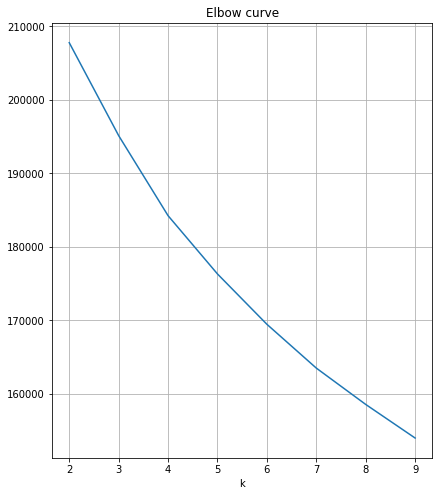

In [172]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import metrics
labels = k_means.labels_


# Specifying the dataset and initializing variables
X = _10pct_vect
silhouette_score = {}
distortions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    #labels = k_means.labels_
    #silhouette_score[k] = metrics.silhouette_score(X, labels, metric='euclidean')
    distortions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(2, 10), distortions)
plt.grid(True)

__Optimal number of k's is 4__

In [170]:
silhouette_score

{2: 0.11773802,
 3: 0.11773802,
 4: 0.11773802,
 5: 0.11773802,
 6: 0.11773802,
 7: 0.11773802,
 8: 0.11773802,
 9: 0.11773802}

The silhouette_score seems to be identical for all the values of k, very strange.

## Using LDA model to derive the topic of each cluster

In [173]:
import gensim
from gensim.utils import simple_preprocess

In [245]:
from gensim import corpora
# Create the Inputs of LDA model: Dictionary and Corpus
dct = corpora.Dictionary(fully_recomposed_notes)
corpus = [dct.doc2bow(note) for note in fully_recomposed_notes]

2019-09-29 22:44:27,360 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-09-29 22:44:27,477 : INFO : adding document #10000 to Dictionary(6064 unique tokens: ['utilities', ':t-shirt:', 'thank', ':mobile_phone:', ':money_with_wings:']...)
2019-09-29 22:44:27,568 : INFO : adding document #20000 to Dictionary(9524 unique tokens: ['utilities', ':t-shirt:', 'thank', ':mobile_phone:', ':money_with_wings:']...)
2019-09-29 22:44:27,651 : INFO : adding document #30000 to Dictionary(12353 unique tokens: ['utilities', ':t-shirt:', 'thank', ':mobile_phone:', ':money_with_wings:']...)
2019-09-29 22:44:27,736 : INFO : adding document #40000 to Dictionary(14946 unique tokens: ['utilities', ':t-shirt:', 'thank', ':mobile_phone:', ':money_with_wings:']...)
2019-09-29 22:44:27,815 : INFO : adding document #50000 to Dictionary(17322 unique tokens: ['utilities', ':t-shirt:', 'thank', ':mobile_phone:', ':money_with_wings:']...)
2019-09-29 22:44:27,896 : INFO : adding document #60000 to D

In [246]:
# Step 4: Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=4,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

2019-09-29 22:45:26,144 : INFO : using asymmetric alpha [0.38961035, 0.25974026, 0.19480518, 0.15584415]
2019-09-29 22:45:26,146 : INFO : using symmetric eta at 0.25
2019-09-29 22:45:26,166 : INFO : using serial LDA version on this node
2019-09-29 22:45:26,217 : INFO : running online LDA training, 4 topics, 10 passes over the supplied corpus of 263365 documents, updating every 3000 documents, evaluating every ~0 documents, iterating 100x with a convergence threshold of 0.001000
2019-09-29 22:45:26,228 : INFO : training LDA model using 3 processes
2019-09-29 22:45:26,334 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/263365, outstanding queue size 1
2019-09-29 22:45:26,428 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/263365, outstanding queue size 2
2019-09-29 22:45:26,431 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #3000/263365, outstanding queue size 3
2019-09-29 22:45:26,433 : INFO : PROGRESS: pass 0, dispatched c

2019-09-29 22:45:30,098 : INFO : PROGRESS: pass 0, dispatched chunk #22 = documents up to #23000/263365, outstanding queue size 9
2019-09-29 22:45:30,251 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:30,335 : INFO : topic #0 (0.390): 0.013*":money_with_wings:" + 0.010*"food" + 0.009*":house:" + 0.007*":man_dancing_light_skin_tone:" + 0.006*"for" + 0.005*":party_popper:" + 0.005*"thank" + 0.005*":fuel_pump:" + 0.005*"july" + 0.005*":face_blowing_a_kiss:"
2019-09-29 22:45:30,340 : INFO : topic #1 (0.260): 0.016*":hot_beverage:" + 0.014*":red_heart:" + 0.014*":pizza:" + 0.012*"thanks" + 0.009*"i" + 0.006*"rent" + 0.005*":automobile:" + 0.005*":tropical_drink:" + 0.005*":taco:" + 0.004*"internet"
2019-09-29 22:45:30,343 : INFO : topic #2 (0.195): 0.006*":poultry_leg:" + 0.006*":bread:" + 0.005*":flag_in_hole:" + 0.004*":ice_hockey:" + 0.004*":pizza:" + 0.004*":french_fries:" + 0.003*":ice_skate:" + 0.003*":mushroom:" + 0.003*":spaghetti:" + 

2019-09-29 22:45:32,550 : INFO : PROGRESS: pass 0, dispatched chunk #37 = documents up to #38000/263365, outstanding queue size 9
2019-09-29 22:45:32,631 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:32,703 : INFO : topic #0 (0.390): 0.014*":money_with_wings:" + 0.012*"food" + 0.010*":house:" + 0.007*":wine_glass:" + 0.007*":beer_mug:" + 0.007*"for" + 0.006*":clinking_beer_mugs:" + 0.006*"thank" + 0.006*":party_popper:" + 0.006*":fuel_pump:"
2019-09-29 22:45:32,705 : INFO : topic #1 (0.260): 0.070*":pizza:" + 0.022*":red_heart:" + 0.018*"thanks" + 0.014*"i" + 0.012*":hot_beverage:" + 0.011*":tropical_drink:" + 0.008*"rent" + 0.007*":automobile:" + 0.006*":bottle_with_popping_cork:" + 0.006*":baseball:"
2019-09-29 22:45:32,707 : INFO : topic #2 (0.195): 0.011*":poultry_leg:" + 0.011*":flag_in_hole:" + 0.006*":spaghetti:" + 0.006*":bread:" + 0.005*":french_fries:" + 0.005*":hot_dog:" + 0.005*":dress:" + 0.003*"golf" + 0.003*"salad" + 0.003

2019-09-29 22:45:34,996 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:35,125 : INFO : topic #0 (0.390): 0.013*"food" + 0.013*":money_with_wings:" + 0.010*":house:" + 0.009*":beer_mug:" + 0.007*":wine_glass:" + 0.007*"for" + 0.007*":clinking_beer_mugs:" + 0.006*"uber" + 0.006*"thank" + 0.006*":fuel_pump:"
2019-09-29 22:45:35,128 : INFO : topic #1 (0.260): 0.062*":pizza:" + 0.028*":red_heart:" + 0.020*"i" + 0.019*"thanks" + 0.014*":tropical_drink:" + 0.011*":automobile:" + 0.010*":hot_beverage:" + 0.009*"rent" + 0.008*":bottle_with_popping_cork:" + 0.007*"love"
2019-09-29 22:45:35,130 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.010*":french_fries:" + 0.010*":flag_in_hole:" + 0.007*":spaghetti:" + 0.006*":bread:" + 0.005*":meat_on_bone:" + 0.004*":regional_indicator_symbol_letter_i:" + 0.004*"kale" + 0.004*"golf" + 0.004*"hey"
2019-09-29 22:45:35,132 : INFO : topic #3 (0.156): 0.039*":taco:" + 0.010*":burrito:" + 0.008*"poker" + 0.

2019-09-29 22:45:37,850 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.013*"food" + 0.009*"uber" + 0.008*":beer_mug:" + 0.008*"for" + 0.006*":fuel_pump:" + 0.006*":clinking_beer_mugs:" + 0.006*"thank" + 0.006*":face_blowing_a_kiss:"
2019-09-29 22:45:37,860 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.031*":red_heart:" + 0.025*"i" + 0.018*"thanks" + 0.015*":tropical_drink:" + 0.014*":automobile:" + 0.013*"rent" + 0.011*":hot_beverage:" + 0.009*"love" + 0.008*":bottle_with_popping_cork:"
2019-09-29 22:45:37,863 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.014*":french_fries:" + 0.008*":spaghetti:" + 0.008*":flag_in_hole:" + 0.007*":bread:" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:" + 0.004*":meat_on_bone:" + 0.004*"hey"
2019-09-29 22:45:37,865 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.012*":burrito:" + 0.009*"poker" + 0.007*":peach:" + 0.005*":smiling_face_with_heart-eyes:" + 0.004*":loudly_crying_face:" + 0.004*":avocado:" + 0.004*

2019-09-29 22:45:40,100 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.030*":red_heart:" + 0.027*"i" + 0.022*":hot_beverage:" + 0.018*"thanks" + 0.017*"rent" + 0.015*":automobile:" + 0.013*":tropical_drink:" + 0.010*"love" + 0.009*":bottle_with_popping_cork:"
2019-09-29 22:45:40,138 : INFO : topic #2 (0.195): 0.015*":poultry_leg:" + 0.013*":french_fries:" + 0.012*":flag_in_hole:" + 0.009*":bread:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":dress:" + 0.004*"chicken"
2019-09-29 22:45:40,140 : INFO : topic #3 (0.156): 0.041*":taco:" + 0.014*":burrito:" + 0.008*":peach:" + 0.006*"poker" + 0.006*":loudly_crying_face:" + 0.005*":smiling_face_with_heart-eyes:" + 0.004*":water_wave:" + 0.004*":avocado:" + 0.003*":oncoming_taxi:" + 0.003*"top"
2019-09-29 22:45:40,142 : INFO : topic diff=0.108459, rho=0.085749
2019-09-29 22:45:40,143 : INFO : PROGRESS: pass 0, dispatched chunk #83 = documents up to #84000/263365, outstanding queue size 9
2019-09-29 22

2019-09-29 22:45:41,903 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.014*":french_fries:" + 0.014*":flag_in_hole:" + 0.012*":moai:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.005*":hot_dog:" + 0.005*":dress:" + 0.005*"rocket" + 0.005*":baguette_bread:"
2019-09-29 22:45:41,905 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.018*":burrito:" + 0.008*":peach:" + 0.006*":avocado:" + 0.006*":smiling_face_with_heart-eyes:" + 0.006*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"poker" + 0.004*":water_wave:" + 0.004*":penguin:"
2019-09-29 22:45:41,906 : INFO : topic diff=0.098433, rho=0.081379
2019-09-29 22:45:41,908 : INFO : PROGRESS: pass 0, dispatched chunk #98 = documents up to #99000/263365, outstanding queue size 8
2019-09-29 22:45:41,912 : INFO : PROGRESS: pass 0, dispatched chunk #99 = documents up to #100000/263365, outstanding queue size 8
2019-09-29 22:45:41,913 : INFO : PROGRESS: pass 0, dispatched chunk #100 = documents up to #101000/263365, outstanding queue 

2019-09-29 22:45:43,547 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.018*":burrito:" + 0.007*":peach:" + 0.007*":avocado:" + 0.006*":water_wave:" + 0.005*":smiling_face_with_heart-eyes:" + 0.005*":stuffed_flatbread:" + 0.005*":loudly_crying_face:" + 0.003*":oncoming_taxi:" + 0.003*"top"
2019-09-29 22:45:43,548 : INFO : topic diff=0.076810, rho=0.077382
2019-09-29 22:45:43,550 : INFO : PROGRESS: pass 0, dispatched chunk #114 = documents up to #115000/263365, outstanding queue size 9
2019-09-29 22:45:43,553 : INFO : PROGRESS: pass 0, dispatched chunk #115 = documents up to #116000/263365, outstanding queue size 9
2019-09-29 22:45:43,709 : INFO : PROGRESS: pass 0, dispatched chunk #116 = documents up to #117000/263365, outstanding queue size 9
2019-09-29 22:45:43,753 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:43,822 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.013*"food" + 0.007*"for" + 0.007*"august" + 0.

2019-09-29 22:45:45,164 : INFO : topic diff=0.069643, rho=0.074125
2019-09-29 22:45:45,165 : INFO : PROGRESS: pass 0, dispatched chunk #129 = documents up to #130000/263365, outstanding queue size 9
2019-09-29 22:45:45,195 : INFO : PROGRESS: pass 0, dispatched chunk #130 = documents up to #131000/263365, outstanding queue size 9
2019-09-29 22:45:45,328 : INFO : PROGRESS: pass 0, dispatched chunk #131 = documents up to #132000/263365, outstanding queue size 9
2019-09-29 22:45:45,427 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:45,499 : INFO : topic #0 (0.390): 0.021*":money_with_wings:" + 0.018*":house:" + 0.014*"food" + 0.008*"for" + 0.007*"thank" + 0.007*":party_popper:" + 0.007*":beer_mug:" + 0.007*":fuel_pump:" + 0.006*":clinking_beer_mugs:" + 0.006*"august"
2019-09-29 22:45:45,501 : INFO : topic #1 (0.260): 0.054*":pizza:" + 0.033*":red_heart:" + 0.028*"i" + 0.019*"thanks" + 0.017*":hot_beverage:" + 0.016*":tropical_drink:" + 0.015*

2019-09-29 22:45:46,829 : INFO : PROGRESS: pass 0, dispatched chunk #144 = documents up to #145000/263365, outstanding queue size 9
2019-09-29 22:45:46,984 : INFO : PROGRESS: pass 0, dispatched chunk #145 = documents up to #146000/263365, outstanding queue size 9
2019-09-29 22:45:47,084 : INFO : PROGRESS: pass 0, dispatched chunk #146 = documents up to #147000/263365, outstanding queue size 9
2019-09-29 22:45:47,238 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:47,318 : INFO : topic #0 (0.390): 0.021*":steaming_bowl:" + 0.018*":money_with_wings:" + 0.016*":house:" + 0.015*"food" + 0.009*":beer_mug:" + 0.008*":clinking_beer_mugs:" + 0.007*"for" + 0.007*":wine_glass:" + 0.007*"thank" + 0.007*":party_popper:"
2019-09-29 22:45:47,322 : INFO : topic #1 (0.260): 0.058*":pizza:" + 0.032*":red_heart:" + 0.029*"i" + 0.019*"thanks" + 0.017*":tropical_drink:" + 0.014*":automobile:" + 0.014*":hot_beverage:" + 0.011*"rent" + 0.010*":bottle_with_poppi

2019-09-29 22:45:49,063 : INFO : PROGRESS: pass 0, dispatched chunk #160 = documents up to #161000/263365, outstanding queue size 9
2019-09-29 22:45:49,177 : INFO : PROGRESS: pass 0, dispatched chunk #161 = documents up to #162000/263365, outstanding queue size 9
2019-09-29 22:45:49,225 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:49,290 : INFO : topic #0 (0.390): 0.016*":steaming_bowl:" + 0.016*":money_with_wings:" + 0.015*"food" + 0.014*":house:" + 0.011*":beer_mug:" + 0.010*":squid:" + 0.009*":clinking_beer_mugs:" + 0.008*":wine_glass:" + 0.008*"uber" + 0.008*"thank"
2019-09-29 22:45:49,292 : INFO : topic #1 (0.260): 0.060*":pizza:" + 0.031*"i" + 0.030*":red_heart:" + 0.020*":tropical_drink:" + 0.018*"thanks" + 0.015*":automobile:" + 0.011*"love" + 0.011*":hot_beverage:" + 0.010*":bottle_with_popping_cork:" + 0.010*"rent"
2019-09-29 22:45:49,294 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.014*":flag_

2019-09-29 22:45:50,705 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:50,810 : INFO : topic #0 (0.390): 0.016*"food" + 0.015*":money_with_wings:" + 0.013*":steaming_bowl:" + 0.012*"uber" + 0.012*":beer_mug:" + 0.012*":house:" + 0.010*":clinking_beer_mugs:" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*":squid:"
2019-09-29 22:45:50,813 : INFO : topic #1 (0.260): 0.061*":pizza:" + 0.032*"i" + 0.030*":red_heart:" + 0.022*":tropical_drink:" + 0.018*"thanks" + 0.016*":automobile:" + 0.013*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:45:50,814 : INFO : topic #2 (0.195): 0.020*":french_fries:" + 0.020*":poultry_leg:" + 0.012*":flag_in_hole:" + 0.010*":spaghetti:" + 0.010*":bread:" + 0.006*"hey" + 0.006*":meat_on_bone:" + 0.005*"kale" + 0.005*"chicken" + 0.005*"rocket"
2019-09-29 22:45:50,816 : INFO : topic #3 (0.156): 0.054*":taco:" + 0.014*":burrito:" + 0.011*":peach:" + 0.007*"poker" + 0.007

2019-09-29 22:45:52,342 : INFO : topic #1 (0.260): 0.057*":pizza:" + 0.033*"i" + 0.031*":red_heart:" + 0.021*":tropical_drink:" + 0.018*":automobile:" + 0.017*"thanks" + 0.014*"love" + 0.013*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:45:52,344 : INFO : topic #2 (0.195): 0.029*":poultry_leg:" + 0.022*":french_fries:" + 0.010*":flag_in_hole:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*"hot"
2019-09-29 22:45:52,345 : INFO : topic #3 (0.156): 0.058*":taco:" + 0.016*":burrito:" + 0.011*":peach:" + 0.010*"poker" + 0.006*":smiling_face_with_heart-eyes:" + 0.006*":avocado:" + 0.005*":water_wave:" + 0.005*":penguin:" + 0.004*":loudly_crying_face:" + 0.004*"cheese"
2019-09-29 22:45:52,347 : INFO : topic diff=0.059529, rho=0.063888
2019-09-29 22:45:52,348 : INFO : PROGRESS: pass 0, dispatched chunk #192 = documents up to #193000/263365, outstanding queue size 9
2019-09-29 22:45:52,

2019-09-29 22:45:53,915 : INFO : topic #2 (0.195): 0.025*":poultry_leg:" + 0.019*":french_fries:" + 0.018*":flag_in_hole:" + 0.009*":spaghetti:" + 0.009*":bread:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":meat_on_bone:"
2019-09-29 22:45:53,955 : INFO : topic #3 (0.156): 0.052*":taco:" + 0.014*":burrito:" + 0.010*":peach:" + 0.009*"poker" + 0.007*":smiling_face_with_heart-eyes:" + 0.006*":water_wave:" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"beers"
2019-09-29 22:45:53,957 : INFO : topic diff=0.054030, rho=0.062017
2019-09-29 22:45:53,958 : INFO : PROGRESS: pass 0, dispatched chunk #207 = documents up to #208000/263365, outstanding queue size 9
2019-09-29 22:45:53,963 : INFO : PROGRESS: pass 0, dispatched chunk #208 = documents up to #209000/263365, outstanding queue size 9
2019-09-29 22:45:54,134 : INFO : PROGRESS: pass 0, dispatched chunk #209 = documents up to #210000/263365, outstanding queue size 9
2019-09-2

2019-09-29 22:45:55,430 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.014*":burrito:" + 0.010*":peach:" + 0.009*":smiling_face_with_heart-eyes:" + 0.007*"poker" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"cheese"
2019-09-29 22:45:55,432 : INFO : topic diff=0.048313, rho=0.060302
2019-09-29 22:45:55,434 : INFO : PROGRESS: pass 0, dispatched chunk #222 = documents up to #223000/263365, outstanding queue size 9
2019-09-29 22:45:55,507 : INFO : PROGRESS: pass 0, dispatched chunk #223 = documents up to #224000/263365, outstanding queue size 9
2019-09-29 22:45:55,592 : INFO : PROGRESS: pass 0, dispatched chunk #224 = documents up to #225000/263365, outstanding queue size 9
2019-09-29 22:45:55,645 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:55,716 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"uber" + 0.015*":house:" + 0.014*"food" + 0.010*":beer_mug:" + 0.008*":

2019-09-29 22:45:57,016 : INFO : topic diff=0.053584, rho=0.058722
2019-09-29 22:45:57,017 : INFO : PROGRESS: pass 0, dispatched chunk #237 = documents up to #238000/263365, outstanding queue size 9
2019-09-29 22:45:57,100 : INFO : PROGRESS: pass 0, dispatched chunk #238 = documents up to #239000/263365, outstanding queue size 9
2019-09-29 22:45:57,122 : INFO : PROGRESS: pass 0, dispatched chunk #239 = documents up to #240000/263365, outstanding queue size 9
2019-09-29 22:45:57,234 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:57,303 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.015*":house:" + 0.014*"uber" + 0.014*"food" + 0.010*":beer_mug:" + 0.008*":clinking_beer_mugs:" + 0.008*"for" + 0.008*":fuel_pump:" + 0.007*"thank" + 0.007*":party_popper:"
2019-09-29 22:45:57,306 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.031*"i" + 0.029*":red_heart:" + 0.023*":hot_beverage:" + 0.020*":tropical_drink:" + 0.017*":cooking:" + 0.017

2019-09-29 22:45:58,808 : INFO : PROGRESS: pass 0, dispatched chunk #253 = documents up to #254000/263365, outstanding queue size 9
2019-09-29 22:45:58,884 : INFO : PROGRESS: pass 0, dispatched chunk #254 = documents up to #255000/263365, outstanding queue size 9
2019-09-29 22:45:58,991 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:45:59,080 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.015*"food" + 0.015*":house:" + 0.013*"uber" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:" + 0.007*"thank"
2019-09-29 22:45:59,083 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.022*":tropical_drink:" + 0.021*":hot_beverage:" + 0.018*":cooking:" + 0.017*"thanks" + 0.016*":automobile:" + 0.014*":bottle_with_popping_cork:" + 0.012*"love"
2019-09-29 22:45:59,085 : INFO : topic #2 (0.195): 0.023*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.016*":french

2019-09-29 22:46:00,421 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.016*":french_fries:" + 0.013*":stadium:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.007*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*"hey"
2019-09-29 22:46:00,423 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.010*":peach:" + 0.010*":smiling_face_with_heart-eyes:" + 0.008*":water_wave:" + 0.008*":avocado:" + 0.004*":loudly_crying_face:" + 0.004*"cheese" + 0.004*":oncoming_taxi:" + 0.004*"beers"
2019-09-29 22:46:00,425 : INFO : topic diff=0.048301, rho=0.055641
2019-09-29 22:46:00,435 : INFO : merging changes from 1000 documents into a model of 263365 documents
2019-09-29 22:46:00,463 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.013*":house:" + 0.012*"uber" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.007*"for" + 0.007*":wine_glass:" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:46:00,465 : INFO : t

2019-09-29 22:46:01,820 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:01,854 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.013*":house:" + 0.010*"uber" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.007*"thank" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:46:01,857 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.028*"i" + 0.028*":red_heart:" + 0.020*":hot_beverage:" + 0.019*":tropical_drink:" + 0.017*"thanks" + 0.015*":automobile:" + 0.014*":bottle_with_popping_cork:" + 0.013*":cooking:" + 0.011*"love"
2019-09-29 22:46:01,860 : INFO : topic #2 (0.195): 0.020*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.017*":french_fries:" + 0.014*":bread:" + 0.010*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*":meat_on_bone:" + 0.005*":dress:"
2019-09-29 22:46:01,862 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.017*":burrito:" + 0.011*":smiling_face_with_hea

2019-09-29 22:46:03,182 : INFO : topic #0 (0.390): 0.016*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.007*":party_popper:"
2019-09-29 22:46:03,184 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.019*"thanks" + 0.018*":tropical_drink:" + 0.018*":hot_beverage:" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.011*"love" + 0.010*":cooking:"
2019-09-29 22:46:03,186 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.015*":french_fries:" + 0.013*":bread:" + 0.008*":spaghetti:" + 0.008*":stadium:" + 0.007*":hot_dog:" + 0.006*":dress:" + 0.005*"golf" + 0.005*"chicken"
2019-09-29 22:46:03,188 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.017*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.009*":water_wave:" + 0.009*":avocado:" + 0.005*":stuffed_flatbread:" + 0.005

2019-09-29 22:46:04,577 : INFO : topic #1 (0.260): 0.054*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.019*"thanks" + 0.019*":tropical_drink:" + 0.015*":hot_beverage:" + 0.013*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.011*"love" + 0.009*":baseball:"
2019-09-29 22:46:04,579 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.017*":french_fries:" + 0.017*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":stadium:" + 0.005*"golf" + 0.005*"chicken" + 0.005*":meat_on_bone:"
2019-09-29 22:46:04,581 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*":avocado:" + 0.005*"poker" + 0.005*":stuffed_flatbread:" + 0.004*"cheese" + 0.004*"sweet"
2019-09-29 22:46:04,583 : INFO : topic diff=0.050105, rho=0.055185
2019-09-29 22:46:04,584 : INFO : PROGRESS: pass 1, dispatched chunk #50 = documents up to #51000/263365, outstanding queue size 9
2019-09-2

2019-09-29 22:46:05,946 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.020*":french_fries:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*"chicken" + 0.006*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*":folded_hands:" + 0.005*"la"
2019-09-29 22:46:05,948 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.007*":avocado:" + 0.005*"cheese" + 0.004*":oncoming_taxi:" + 0.004*":loudly_crying_face:"
2019-09-29 22:46:05,950 : INFO : topic diff=0.051106, rho=0.055185
2019-09-29 22:46:05,951 : INFO : PROGRESS: pass 1, dispatched chunk #65 = documents up to #66000/263365, outstanding queue size 9
2019-09-29 22:46:06,070 : INFO : PROGRESS: pass 1, dispatched chunk #66 = documents up to #67000/263365, outstanding queue size 9
2019-09-29 22:46:06,105 : INFO : PROGRESS: pass 1, dispatched chunk #67 = documents up to #68000/263365, outstanding queue size 9
2

2019-09-29 22:46:07,328 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.006*"poker" + 0.006*":loudly_crying_face:" + 0.004*"cheese" + 0.004*"shirts"
2019-09-29 22:46:07,329 : INFO : topic diff=0.047469, rho=0.055185
2019-09-29 22:46:07,330 : INFO : PROGRESS: pass 1, dispatched chunk #80 = documents up to #81000/263365, outstanding queue size 9
2019-09-29 22:46:07,382 : INFO : PROGRESS: pass 1, dispatched chunk #81 = documents up to #82000/263365, outstanding queue size 9
2019-09-29 22:46:07,432 : INFO : PROGRESS: pass 1, dispatched chunk #82 = documents up to #83000/263365, outstanding queue size 9
2019-09-29 22:46:07,537 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:07,605 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.013*"food" + 0.009*"uber" + 0.008*":beer_mug:" + 0.008*"for" + 0.007*":c

2019-09-29 22:46:08,713 : INFO : topic diff=0.043510, rho=0.055185
2019-09-29 22:46:08,714 : INFO : PROGRESS: pass 1, dispatched chunk #95 = documents up to #96000/263365, outstanding queue size 9
2019-09-29 22:46:08,806 : INFO : PROGRESS: pass 1, dispatched chunk #96 = documents up to #97000/263365, outstanding queue size 9
2019-09-29 22:46:08,887 : INFO : PROGRESS: pass 1, dispatched chunk #97 = documents up to #98000/263365, outstanding queue size 9
2019-09-29 22:46:08,933 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:08,966 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.013*"food" + 0.008*"for" + 0.008*"uber" + 0.007*":beer_mug:" + 0.007*"thank" + 0.007*"august" + 0.007*":party_popper:" + 0.007*"rent"
2019-09-29 22:46:08,968 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.031*"i" + 0.030*":red_heart:" + 0.020*":hot_beverage:" + 0.017*"thanks" + 0.015*":tropical_drink:" + 0.014*":automobile:" + 0.013*"rent"

2019-09-29 22:46:10,242 : INFO : PROGRESS: pass 1, dispatched chunk #112 = documents up to #113000/263365, outstanding queue size 9
2019-09-29 22:46:10,302 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:10,406 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"thank" + 0.007*"august" + 0.007*":party_popper:" + 0.007*"uber" + 0.007*":beer_mug:" + 0.007*"rent"
2019-09-29 22:46:10,408 : INFO : topic #1 (0.260): 0.047*":pizza:" + 0.031*"i" + 0.030*":red_heart:" + 0.018*":hot_beverage:" + 0.017*"thanks" + 0.015*":tropical_drink:" + 0.014*":automobile:" + 0.013*"rent" + 0.011*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:10,410 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.013*":bread:" + 0.008*":moai:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.005*":dress:" + 0.005*"chicken" + 0.005*":folded_hands:"
2019-09-29 

2019-09-29 22:46:11,668 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:11,737 : INFO : topic #0 (0.390): 0.022*":money_with_wings:" + 0.018*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.007*":party_popper:" + 0.007*":beer_mug:" + 0.007*":fuel_pump:" + 0.007*"august" + 0.007*":clinking_beer_mugs:"
2019-09-29 22:46:11,739 : INFO : topic #1 (0.260): 0.044*":pizza:" + 0.031*":red_heart:" + 0.031*"i" + 0.018*"thanks" + 0.017*":hot_beverage:" + 0.015*":tropical_drink:" + 0.015*":automobile:" + 0.012*"rent" + 0.011*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:11,741 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.007*":moai:" + 0.007*":spaghetti:" + 0.006*"chicken" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:46:11,743 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.016*":burrito:" + 0.012*":smiling_face_with_heart-

2019-09-29 22:46:13,063 : INFO : topic #0 (0.390): 0.020*":money_with_wings:" + 0.017*":house:" + 0.016*"food" + 0.009*":beer_mug:" + 0.008*"for" + 0.008*"thank" + 0.008*":clinking_beer_mugs:" + 0.007*":party_popper:" + 0.007*":wine_glass:" + 0.007*":fuel_pump:"
2019-09-29 22:46:13,066 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.031*"i" + 0.030*":red_heart:" + 0.018*"thanks" + 0.016*":tropical_drink:" + 0.014*":hot_beverage:" + 0.014*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.011*"rent" + 0.010*"love"
2019-09-29 22:46:13,068 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.009*":spaghetti:" + 0.006*"chicken" + 0.005*":moai:" + 0.005*":meat_on_bone:" + 0.005*":folded_hands:" + 0.005*":hot_dog:"
2019-09-29 22:46:13,070 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.016*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_cryi

2019-09-29 22:46:14,415 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*":steaming_bowl:" + 0.016*"food" + 0.015*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*":wine_glass:" + 0.008*"uber" + 0.008*"for" + 0.008*"thank"
2019-09-29 22:46:14,417 : INFO : topic #1 (0.260): 0.054*":pizza:" + 0.031*"i" + 0.029*":red_heart:" + 0.018*":tropical_drink:" + 0.017*"thanks" + 0.014*":automobile:" + 0.012*":hot_beverage:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.010*"rent"
2019-09-29 22:46:14,419 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.010*":spaghetti:" + 0.006*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*"chicken" + 0.005*"hey" + 0.005*"rocket"
2019-09-29 22:46:14,421 : INFO : topic #3 (0.156): 0.053*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":penguin:" + 0.007*":avocado:" + 0.007*":water_wave:" + 0.006*":loudly_c

2019-09-29 22:46:15,681 : INFO : topic #1 (0.260): 0.056*":pizza:" + 0.033*"i" + 0.029*":red_heart:" + 0.020*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:46:15,683 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.021*":poultry_leg:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.010*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*"hey" + 0.005*"chicken" + 0.005*":hot_dog:" + 0.005*":folded_hands:"
2019-09-29 22:46:15,685 : INFO : topic #3 (0.156): 0.052*":taco:" + 0.014*":burrito:" + 0.011*":peach:" + 0.011*":smiling_face_with_heart-eyes:" + 0.007*":avocado:" + 0.007*":water_wave:" + 0.006*"poker" + 0.006*":penguin:" + 0.005*":loudly_crying_face:" + 0.004*"beers"
2019-09-29 22:46:15,686 : INFO : topic diff=0.044076, rho=0.055185
2019-09-29 22:46:15,687 : INFO : PROGRESS: pass 1, dispatched chunk #173 = documents up to #174000/263365, outstanding queue size 9
2019-

2019-09-29 22:46:17,080 : INFO : topic #2 (0.195): 0.029*":poultry_leg:" + 0.022*":french_fries:" + 0.011*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*":meat_on_bone:" + 0.005*":hot_dog:" + 0.005*"chicken" + 0.005*"kale"
2019-09-29 22:46:17,081 : INFO : topic #3 (0.156): 0.056*":taco:" + 0.016*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.008*"poker" + 0.006*":avocado:" + 0.006*":water_wave:" + 0.005*"taco" + 0.005*":penguin:" + 0.005*":loudly_crying_face:"
2019-09-29 22:46:17,083 : INFO : topic diff=0.042612, rho=0.055185
2019-09-29 22:46:17,084 : INFO : PROGRESS: pass 1, dispatched chunk #188 = documents up to #189000/263365, outstanding queue size 9
2019-09-29 22:46:17,088 : INFO : PROGRESS: pass 1, dispatched chunk #189 = documents up to #190000/263365, outstanding queue size 9
2019-09-29 22:46:17,174 : INFO : PROGRESS: pass 1, dispatched chunk #190 = documents up to #191000/263365, outstanding queue size 9
2019-09-29 2

2019-09-29 22:46:18,363 : INFO : topic #3 (0.156): 0.052*":taco:" + 0.015*":burrito:" + 0.011*":peach:" + 0.011*":smiling_face_with_heart-eyes:" + 0.008*"poker" + 0.006*":avocado:" + 0.006*":water_wave:" + 0.005*":loudly_crying_face:" + 0.005*"taco" + 0.004*":oncoming_taxi:"
2019-09-29 22:46:18,365 : INFO : topic diff=0.043400, rho=0.055185
2019-09-29 22:46:18,366 : INFO : PROGRESS: pass 1, dispatched chunk #203 = documents up to #204000/263365, outstanding queue size 9
2019-09-29 22:46:18,390 : INFO : PROGRESS: pass 1, dispatched chunk #204 = documents up to #205000/263365, outstanding queue size 9
2019-09-29 22:46:18,473 : INFO : PROGRESS: pass 1, dispatched chunk #205 = documents up to #206000/263365, outstanding queue size 9
2019-09-29 22:46:18,542 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:18,610 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"uber" + 0.016*"food" + 0.015*":house:" + 0.011*":beer_mug:" + 0.009*":cl

2019-09-29 22:46:19,717 : INFO : topic diff=0.042232, rho=0.055185
2019-09-29 22:46:19,719 : INFO : PROGRESS: pass 1, dispatched chunk #218 = documents up to #219000/263365, outstanding queue size 9
2019-09-29 22:46:19,785 : INFO : PROGRESS: pass 1, dispatched chunk #219 = documents up to #220000/263365, outstanding queue size 9
2019-09-29 22:46:19,821 : INFO : PROGRESS: pass 1, dispatched chunk #220 = documents up to #221000/263365, outstanding queue size 9
2019-09-29 22:46:19,928 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:19,956 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"uber" + 0.016*":house:" + 0.015*"food" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.007*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:46:19,959 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.032*"i" + 0.029*":red_heart:" + 0.020*":hot_beverage:" + 0.017*":tropical_drink:" + 0.017*":automobile:" + 0.

2019-09-29 22:46:21,151 : INFO : PROGRESS: pass 1, dispatched chunk #234 = documents up to #235000/263365, outstanding queue size 9
2019-09-29 22:46:21,236 : INFO : PROGRESS: pass 1, dispatched chunk #235 = documents up to #236000/263365, outstanding queue size 9
2019-09-29 22:46:21,286 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:21,356 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"uber" + 0.014*"food" + 0.010*":beer_mug:" + 0.008*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:" + 0.008*":fuel_pump:"
2019-09-29 22:46:21,358 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.022*":hot_beverage:" + 0.018*":tropical_drink:" + 0.017*":automobile:" + 0.016*"thanks" + 0.015*":cooking:" + 0.013*":bottle_with_popping_cork:" + 0.012*"love"
2019-09-29 22:46:21,360 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.016*":french

2019-09-29 22:46:22,961 : INFO : PROGRESS: pass 1, dispatched chunk #250 = documents up to #251000/263365, outstanding queue size 9
2019-09-29 22:46:22,999 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:23,087 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.015*":house:" + 0.015*"food" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:46:23,089 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.020*":hot_beverage:" + 0.020*":tropical_drink:" + 0.017*":cooking:" + 0.016*"thanks" + 0.016*":automobile:" + 0.014*":bottle_with_popping_cork:" + 0.012*"love"
2019-09-29 22:46:23,091 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*"golf" + 0.005*":hot_dog:" + 0.005*"hey" + 0.004*"

2019-09-29 22:46:24,797 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.021*":tropical_drink:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.015*":cooking:" + 0.015*":automobile:" + 0.014*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:24,799 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.016*":french_fries:" + 0.014*":stadium:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*"hey"
2019-09-29 22:46:24,801 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.004*":oncoming_taxi:" + 0.004*"cheese" + 0.004*"taco"
2019-09-29 22:46:24,802 : INFO : topic diff=0.043883, rho=0.055185
2019-09-29 22:46:24,969 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:25,010 : INFO :

2019-09-29 22:46:26,329 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.011*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:46:26,331 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.020*":tropical_drink:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.015*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.013*":cooking:" + 0.011*"love"
2019-09-29 22:46:26,333 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.014*":bread:" + 0.011*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":meat_on_bone:" + 0.005*"golf" + 0.005*":dress:"
2019-09-29 22:46:26,335 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":avocado:" + 0.008*":water_wave:" + 0.005*":stuffed_flatbread:" +

2019-09-29 22:46:27,706 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.018*"thanks" + 0.017*":hot_beverage:" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.010*"love" + 0.010*":cooking:"
2019-09-29 22:46:27,708 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.016*":french_fries:" + 0.013*":bread:" + 0.009*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":dress:" + 0.005*":meat_on_bone:" + 0.005*"golf"
2019-09-29 22:46:27,710 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.009*":avocado:" + 0.009*":water_wave:" + 0.005*":stuffed_flatbread:" + 0.005*"cheese" + 0.005*":loudly_crying_face:" + 0.004*"beers"
2019-09-29 22:46:27,711 : INFO : topic diff=0.042369, rho=0.055101
2019-09-29 22:46:27,714 : INFO : PROGRESS: pass 2, dispatched chunk #32 = documents up to #33000/263365, outstanding queue si

2019-09-29 22:46:29,018 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.017*":flag_in_hole:" + 0.016*":french_fries:" + 0.012*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":stadium:" + 0.006*"chicken" + 0.005*"golf" + 0.005*":meat_on_bone:"
2019-09-29 22:46:29,021 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":stuffed_flatbread:" + 0.005*"poker" + 0.004*"cheese" + 0.004*":loudly_crying_face:"
2019-09-29 22:46:29,022 : INFO : topic diff=0.044966, rho=0.055101
2019-09-29 22:46:29,124 : INFO : PROGRESS: pass 2, dispatched chunk #47 = documents up to #48000/263365, outstanding queue size 9
2019-09-29 22:46:29,129 : INFO : PROGRESS: pass 2, dispatched chunk #48 = documents up to #49000/263365, outstanding queue size 9
2019-09-29 22:46:29,223 : INFO : PROGRESS: pass 2, dispatched chunk #49 = documents up to #50000/263365, outstanding queue size 9


2019-09-29 22:46:30,499 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*"poker" + 0.007*":avocado:" + 0.005*"cheese" + 0.004*":loudly_crying_face:" + 0.004*":oncoming_taxi:"
2019-09-29 22:46:30,501 : INFO : topic diff=0.043059, rho=0.055101
2019-09-29 22:46:30,502 : INFO : PROGRESS: pass 2, dispatched chunk #62 = documents up to #63000/263365, outstanding queue size 9
2019-09-29 22:46:30,508 : INFO : PROGRESS: pass 2, dispatched chunk #63 = documents up to #64000/263365, outstanding queue size 8
2019-09-29 22:46:30,587 : INFO : PROGRESS: pass 2, dispatched chunk #64 = documents up to #65000/263365, outstanding queue size 9
2019-09-29 22:46:30,641 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:30,705 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.014*":house:" + 0.010*"uber" + 0.010*":beer_mug:" + 0.008*":clinki

2019-09-29 22:46:31,861 : INFO : topic diff=0.043115, rho=0.055101
2019-09-29 22:46:31,862 : INFO : PROGRESS: pass 2, dispatched chunk #77 = documents up to #78000/263365, outstanding queue size 9
2019-09-29 22:46:31,933 : INFO : PROGRESS: pass 2, dispatched chunk #78 = documents up to #79000/263365, outstanding queue size 8
2019-09-29 22:46:31,976 : INFO : PROGRESS: pass 2, dispatched chunk #79 = documents up to #80000/263365, outstanding queue size 9
2019-09-29 22:46:32,081 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:32,147 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.014*"food" + 0.009*"uber" + 0.009*":beer_mug:" + 0.008*"for" + 0.008*":clinking_beer_mugs:" + 0.007*"thank" + 0.007*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:46:32,182 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.017*":hot_beverage:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.015*":automo

2019-09-29 22:46:33,252 : INFO : PROGRESS: pass 2, dispatched chunk #93 = documents up to #94000/263365, outstanding queue size 9
2019-09-29 22:46:33,339 : INFO : PROGRESS: pass 2, dispatched chunk #94 = documents up to #95000/263365, outstanding queue size 9
2019-09-29 22:46:33,427 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:33,498 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"uber" + 0.008*":beer_mug:" + 0.008*"thank" + 0.007*"august" + 0.007*":party_popper:" + 0.007*"rent"
2019-09-29 22:46:33,500 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.030*"i" + 0.029*":red_heart:" + 0.019*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.012*"rent" + 0.011*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:33,502 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.017*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0

2019-09-29 22:46:34,739 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:34,765 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"thank" + 0.007*"august" + 0.007*"uber" + 0.007*":party_popper:" + 0.007*":beer_mug:" + 0.007*"rent"
2019-09-29 22:46:34,768 : INFO : topic #1 (0.260): 0.047*":pizza:" + 0.030*"i" + 0.029*":red_heart:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.012*"rent" + 0.011*":bottle_with_popping_cork:" + 0.010*"love"
2019-09-29 22:46:34,770 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.009*":moai:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.005*"chicken" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:46:34,771 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:

2019-09-29 22:46:36,102 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.008*":party_popper:" + 0.007*":beer_mug:" + 0.007*"august" + 0.007*":fuel_pump:" + 0.007*":clinking_beer_mugs:"
2019-09-29 22:46:36,105 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.030*"i" + 0.029*":red_heart:" + 0.017*"thanks" + 0.016*":hot_beverage:" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.011*"rent" + 0.011*":bottle_with_popping_cork:" + 0.010*"love"
2019-09-29 22:46:36,107 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.016*":flag_in_hole:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.007*":moai:" + 0.005*":hot_dog:" + 0.005*"chicken" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:46:36,109 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.016*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0

2019-09-29 22:46:37,401 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.030*"i" + 0.030*":red_heart:" + 0.017*"thanks" + 0.016*":tropical_drink:" + 0.014*":hot_beverage:" + 0.013*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.010*"rent" + 0.010*"love"
2019-09-29 22:46:37,404 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.019*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":moai:" + 0.006*"chicken" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 0.005*":meat_on_bone:"
2019-09-29 22:46:37,406 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.016*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.004*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"cheese"
2019-09-29 22:46:37,408 : INFO : topic diff=0.037455, rho=0.055101
2019-09-29 22:46:37,409 : INFO : PROGRESS: pass 2, dispatched chunk #140 = documents up to #141000/263365, outstanding que

2019-09-29 22:46:38,697 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.030*"i" + 0.029*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.014*":automobile:" + 0.012*":hot_beverage:" + 0.011*":bottle_with_popping_cork:" + 0.011*"love" + 0.009*"rent"
2019-09-29 22:46:38,699 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.009*":spaghetti:" + 0.006*":meat_on_bone:" + 0.005*"chicken" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 0.005*"hey"
2019-09-29 22:46:38,701 : INFO : topic #3 (0.156): 0.053*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.009*":penguin:" + 0.008*":avocado:" + 0.007*":water_wave:" + 0.005*":loudly_crying_face:" + 0.004*"shirts" + 0.004*":stuffed_flatbread:"
2019-09-29 22:46:38,703 : INFO : topic diff=0.042394, rho=0.055101
2019-09-29 22:46:38,704 : INFO : PROGRESS: pass 2, dispatched chunk #155 = documents up to #156000/263365, outstanding que

2019-09-29 22:46:40,026 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.020*":poultry_leg:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.010*":spaghetti:" + 0.006*":meat_on_bone:" + 0.005*"hey" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 0.005*"chicken"
2019-09-29 22:46:40,029 : INFO : topic #3 (0.156): 0.052*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.007*":avocado:" + 0.007*":water_wave:" + 0.006*":penguin:" + 0.006*"poker" + 0.006*":loudly_crying_face:" + 0.004*"beers"
2019-09-29 22:46:40,030 : INFO : topic diff=0.041159, rho=0.055101
2019-09-29 22:46:40,032 : INFO : PROGRESS: pass 2, dispatched chunk #170 = documents up to #171000/263365, outstanding queue size 9
2019-09-29 22:46:40,038 : INFO : PROGRESS: pass 2, dispatched chunk #171 = documents up to #172000/263365, outstanding queue size 9
2019-09-29 22:46:40,146 : INFO : PROGRESS: pass 2, dispatched chunk #172 = documents up to #173000/263365, outstanding queue size 9
2

2019-09-29 22:46:41,427 : INFO : topic #3 (0.156): 0.056*":taco:" + 0.015*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.008*"poker" + 0.006*":avocado:" + 0.006*":water_wave:" + 0.006*"taco" + 0.005*":penguin:" + 0.005*":loudly_crying_face:"
2019-09-29 22:46:41,429 : INFO : topic diff=0.041817, rho=0.055101
2019-09-29 22:46:41,430 : INFO : PROGRESS: pass 2, dispatched chunk #185 = documents up to #186000/263365, outstanding queue size 9
2019-09-29 22:46:41,436 : INFO : PROGRESS: pass 2, dispatched chunk #186 = documents up to #187000/263365, outstanding queue size 8
2019-09-29 22:46:41,437 : INFO : PROGRESS: pass 2, dispatched chunk #187 = documents up to #188000/263365, outstanding queue size 9
2019-09-29 22:46:41,532 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:41,631 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.016*"uber" + 0.013*":house:" + 0.013*":beer_mug:" + 0.011*":steaming

2019-09-29 22:46:42,684 : INFO : topic diff=0.046072, rho=0.055101
2019-09-29 22:46:42,686 : INFO : PROGRESS: pass 2, dispatched chunk #200 = documents up to #201000/263365, outstanding queue size 9
2019-09-29 22:46:42,691 : INFO : PROGRESS: pass 2, dispatched chunk #201 = documents up to #202000/263365, outstanding queue size 9
2019-09-29 22:46:42,809 : INFO : PROGRESS: pass 2, dispatched chunk #202 = documents up to #203000/263365, outstanding queue size 9
2019-09-29 22:46:42,871 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:42,939 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"uber" + 0.016*"food" + 0.015*":house:" + 0.012*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*":steaming_bowl:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:"
2019-09-29 22:46:42,944 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.032*"i" + 0.029*":red_heart:" + 0.018*":tropical_drink:" + 0.017*":automobile:" + 0.016*"thanks" + 0.013*":h

2019-09-29 22:46:44,003 : INFO : PROGRESS: pass 2, dispatched chunk #216 = documents up to #217000/263365, outstanding queue size 9
2019-09-29 22:46:44,082 : INFO : PROGRESS: pass 2, dispatched chunk #217 = documents up to #218000/263365, outstanding queue size 9
2019-09-29 22:46:44,177 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:44,280 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"uber" + 0.016*":house:" + 0.015*"food" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:46:44,282 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.032*"i" + 0.028*":red_heart:" + 0.019*":hot_beverage:" + 0.017*":tropical_drink:" + 0.016*":automobile:" + 0.016*"thanks" + 0.012*":bottle_with_popping_cork:" + 0.012*"love" + 0.010*":cooking:"
2019-09-29 22:46:44,314 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":flag_in_hole:" + 0.017*":french

2019-09-29 22:46:45,459 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:45,562 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"uber" + 0.015*"food" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:46:45,564 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.021*":hot_beverage:" + 0.017*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.014*":cooking:" + 0.013*":bottle_with_popping_cork:" + 0.012*"love"
2019-09-29 22:46:45,566 : INFO : topic #2 (0.195): 0.020*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.010*":bread:" + 0.007*":spaghetti:" + 0.005*":hot_dog:" + 0.005*"hey" + 0.005*"golf" + 0.004*":meat_on_bone:" + 0.004*"rocket"
2019-09-29 22:46:45,568 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes

2019-09-29 22:46:47,039 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"food" + 0.014*"uber" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:46:47,042 : INFO : topic #1 (0.260): 0.036*":pizza:" + 0.029*"i" + 0.026*":red_heart:" + 0.020*":hot_beverage:" + 0.020*":tropical_drink:" + 0.017*":cooking:" + 0.016*":automobile:" + 0.015*"thanks" + 0.013*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:47,061 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*"golf" + 0.005*":hot_dog:" + 0.005*"hey" + 0.004*":dress:"
2019-09-29 22:46:47,063 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.008*":avocado:" + 0.005*":oncoming_taxi:" + 0.005*":l

2019-09-29 22:46:48,389 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.021*":tropical_drink:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.015*":cooking:" + 0.014*":automobile:" + 0.014*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:48,391 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*"hey" + 0.005*":pig_face:"
2019-09-29 22:46:48,393 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.004*":oncoming_taxi:" + 0.004*"cheese" + 0.004*"taco"
2019-09-29 22:46:48,394 : INFO : topic diff=0.039254, rho=0.055101
2019-09-29 22:46:48,395 : INFO : PROGRESS: pass 2, dispatched chunk #263 = documents up to #263365/263365, outstanding queue size 9
2

2019-09-29 22:46:49,686 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.017*":french_fries:" + 0.013*":bread:" + 0.012*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":meat_on_bone:" + 0.005*"golf" + 0.005*":pig_face:"
2019-09-29 22:46:49,688 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":avocado:" + 0.008*":water_wave:" + 0.005*":stuffed_flatbread:" + 0.005*"cheese" + 0.005*":loudly_crying_face:" + 0.004*":oncoming_taxi:"
2019-09-29 22:46:49,689 : INFO : topic diff=0.042337, rho=0.055018
2019-09-29 22:46:49,691 : INFO : PROGRESS: pass 3, dispatched chunk #13 = documents up to #14000/263365, outstanding queue size 8
2019-09-29 22:46:49,699 : INFO : PROGRESS: pass 3, dispatched chunk #14 = documents up to #15000/263365, outstanding queue size 9
2019-09-29 22:46:49,814 : INFO : PROGRESS: pass 3, dispatched chunk #15 = documents up to #16000/263365, outstanding 

2019-09-29 22:46:51,122 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.016*":french_fries:" + 0.013*":bread:" + 0.009*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":dress:" + 0.005*"golf" + 0.005*":meat_on_bone:"
2019-09-29 22:46:51,124 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.009*":avocado:" + 0.009*":water_wave:" + 0.005*"cheese" + 0.005*":stuffed_flatbread:" + 0.005*":loudly_crying_face:" + 0.004*"sweet"
2019-09-29 22:46:51,125 : INFO : topic diff=0.039010, rho=0.055018
2019-09-29 22:46:51,127 : INFO : PROGRESS: pass 3, dispatched chunk #29 = documents up to #30000/263365, outstanding queue size 9
2019-09-29 22:46:51,198 : INFO : PROGRESS: pass 3, dispatched chunk #30 = documents up to #31000/263365, outstanding queue size 9
2019-09-29 22:46:51,257 : INFO : PROGRESS: pass 3, dispatched chunk #31 = documents up to #32000/263365, outstanding queue size 9


2019-09-29 22:46:52,574 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.008*":avocado:" + 0.005*":stuffed_flatbread:" + 0.004*"cheese" + 0.004*":loudly_crying_face:" + 0.004*"sweet"
2019-09-29 22:46:52,576 : INFO : topic diff=0.041774, rho=0.055018
2019-09-29 22:46:52,577 : INFO : PROGRESS: pass 3, dispatched chunk #44 = documents up to #45000/263365, outstanding queue size 9
2019-09-29 22:46:52,671 : INFO : PROGRESS: pass 3, dispatched chunk #45 = documents up to #46000/263365, outstanding queue size 9
2019-09-29 22:46:52,734 : INFO : PROGRESS: pass 3, dispatched chunk #46 = documents up to #47000/263365, outstanding queue size 9
2019-09-29 22:46:52,741 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:52,824 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.012*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mug

2019-09-29 22:46:54,134 : INFO : topic diff=0.045955, rho=0.055018
2019-09-29 22:46:54,135 : INFO : PROGRESS: pass 3, dispatched chunk #59 = documents up to #60000/263365, outstanding queue size 9
2019-09-29 22:46:54,242 : INFO : PROGRESS: pass 3, dispatched chunk #60 = documents up to #61000/263365, outstanding queue size 9
2019-09-29 22:46:54,301 : INFO : PROGRESS: pass 3, dispatched chunk #61 = documents up to #62000/263365, outstanding queue size 9
2019-09-29 22:46:54,342 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:54,415 : INFO : topic #0 (0.390): 0.016*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.007*":fuel_pump:"
2019-09-29 22:46:54,417 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.017*"thanks" + 0.017*":tropical_drink:" + 0.014*":automobile:" + 0.013*":hot_bevera

2019-09-29 22:46:55,509 : INFO : PROGRESS: pass 3, dispatched chunk #74 = documents up to #75000/263365, outstanding queue size 9
2019-09-29 22:46:55,598 : INFO : PROGRESS: pass 3, dispatched chunk #75 = documents up to #76000/263365, outstanding queue size 9
2019-09-29 22:46:55,648 : INFO : PROGRESS: pass 3, dispatched chunk #76 = documents up to #77000/263365, outstanding queue size 9
2019-09-29 22:46:55,721 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:55,794 : INFO : topic #0 (0.390): 0.022*":money_with_wings:" + 0.019*":house:" + 0.014*"food" + 0.010*"uber" + 0.009*":beer_mug:" + 0.008*"for" + 0.008*":clinking_beer_mugs:" + 0.008*"thank" + 0.007*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:46:55,803 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":hot_beverage:" + 0.015*":tropical_drink:" + 0.014*":automobile:" + 0.011*"rent" + 0.011*":bottle_with_popping_cork:" + 0.011*

2019-09-29 22:46:57,213 : INFO : PROGRESS: pass 3, dispatched chunk #91 = documents up to #92000/263365, outstanding queue size 9
2019-09-29 22:46:57,243 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:46:57,313 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.009*"for" + 0.008*"uber" + 0.008*":beer_mug:" + 0.008*"thank" + 0.007*"august" + 0.007*":party_popper:" + 0.007*":clinking_beer_mugs:"
2019-09-29 22:46:57,315 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":automobile:" + 0.014*":tropical_drink:" + 0.011*"rent" + 0.011*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:46:57,317 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*":dress:" + 0.005*"rocke

2019-09-29 22:46:58,637 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"thank" + 0.008*"uber" + 0.007*"august" + 0.007*":party_popper:" + 0.007*":beer_mug:" + 0.007*"rent"
2019-09-29 22:46:58,639 : INFO : topic #1 (0.260): 0.035*":pizza:" + 0.030*"i" + 0.029*":red_heart:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.012*"rent" + 0.011*":bottle_with_popping_cork:" + 0.010*"love"
2019-09-29 22:46:58,641 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.009*":moai:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.005*"chicken" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:46:58,643 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbrea

2019-09-29 22:46:59,922 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.029*":red_heart:" + 0.028*"i" + 0.017*"thanks" + 0.016*":hot_beverage:" + 0.014*":automobile:" + 0.014*":tropical_drink:" + 0.011*"rent" + 0.011*":bottle_with_popping_cork:" + 0.010*"love"
2019-09-29 22:46:59,924 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.007*":moai:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.005*":dress:" + 0.005*":folded_hands:" + 0.005*"chicken"
2019-09-29 22:46:59,925 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.016*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.003*"poker"
2019-09-29 22:46:59,927 : INFO : topic diff=0.040308, rho=0.055018
2019-09-29 22:46:59,928 : INFO : PROGRESS: pass 3, dispatched chunk #122 = documents up to #123000/263365, outstanding queue size 

2019-09-29 22:47:01,283 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":moai:" + 0.006*"chicken" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:47:01,286 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.004*":stuffed_flatbread:" + 0.004*"shirts" + 0.003*"cheese"
2019-09-29 22:47:01,287 : INFO : topic diff=0.040271, rho=0.055018
2019-09-29 22:47:01,289 : INFO : PROGRESS: pass 3, dispatched chunk #137 = documents up to #138000/263365, outstanding queue size 9
2019-09-29 22:47:01,366 : INFO : PROGRESS: pass 3, dispatched chunk #138 = documents up to #139000/263365, outstanding queue size 9
2019-09-29 22:47:01,379 : INFO : PROGRESS: pass 3, dispatched chunk #139 = documents up to #140000/263365, outstanding queue 

2019-09-29 22:47:02,587 : INFO : topic #3 (0.156): 0.054*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.009*":penguin:" + 0.008*":avocado:" + 0.007*":water_wave:" + 0.005*":loudly_crying_face:" + 0.004*"shirts" + 0.004*":stuffed_flatbread:"
2019-09-29 22:47:02,590 : INFO : topic diff=0.038607, rho=0.055018
2019-09-29 22:47:02,593 : INFO : PROGRESS: pass 3, dispatched chunk #152 = documents up to #153000/263365, outstanding queue size 9
2019-09-29 22:47:02,642 : INFO : PROGRESS: pass 3, dispatched chunk #153 = documents up to #154000/263365, outstanding queue size 9
2019-09-29 22:47:02,737 : INFO : PROGRESS: pass 3, dispatched chunk #154 = documents up to #155000/263365, outstanding queue size 9
2019-09-29 22:47:02,762 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:02,830 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.017*":steaming_bowl:" + 0.016*":house:" + 0.016*"food" + 0.011*":be

2019-09-29 22:47:03,906 : INFO : topic diff=0.044675, rho=0.055018
2019-09-29 22:47:03,909 : INFO : PROGRESS: pass 3, dispatched chunk #167 = documents up to #168000/263365, outstanding queue size 9
2019-09-29 22:47:03,987 : INFO : PROGRESS: pass 3, dispatched chunk #168 = documents up to #169000/263365, outstanding queue size 9
2019-09-29 22:47:04,077 : INFO : PROGRESS: pass 3, dispatched chunk #169 = documents up to #170000/263365, outstanding queue size 9
2019-09-29 22:47:04,115 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:04,187 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.014*":house:" + 0.014*":steaming_bowl:" + 0.012*":beer_mug:" + 0.010*"uber" + 0.010*":clinking_beer_mugs:" + 0.009*":wine_glass:" + 0.008*"thank" + 0.008*"for"
2019-09-29 22:47:04,189 : INFO : topic #1 (0.260): 0.054*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.014*":automobile:" + 0.011*"l

2019-09-29 22:47:05,267 : INFO : PROGRESS: pass 3, dispatched chunk #183 = documents up to #184000/263365, outstanding queue size 9
2019-09-29 22:47:05,352 : INFO : PROGRESS: pass 3, dispatched chunk #184 = documents up to #185000/263365, outstanding queue size 9
2019-09-29 22:47:05,403 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:05,468 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.014*"uber" + 0.013*":house:" + 0.013*":beer_mug:" + 0.012*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:"
2019-09-29 22:47:05,470 : INFO : topic #1 (0.260): 0.054*":pizza:" + 0.032*"i" + 0.028*":red_heart:" + 0.020*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.013*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:47:05,473 : INFO : topic #2 (0.195): 0.031*":poultry_leg:" + 0.022*":french_fries:" + 0.012*":flag_in_

2019-09-29 22:47:06,726 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:06,795 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"uber" + 0.017*"food" + 0.015*":house:" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.009*":steaming_bowl:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:"
2019-09-29 22:47:06,798 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.032*"i" + 0.029*":red_heart:" + 0.018*":tropical_drink:" + 0.017*":automobile:" + 0.016*"thanks" + 0.013*"love" + 0.013*":bottle_with_popping_cork:" + 0.012*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:47:06,800 : INFO : topic #2 (0.195): 0.026*":poultry_leg:" + 0.021*":french_fries:" + 0.014*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.006*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:"
2019-09-29 22:47:06,802 : INFO : topic #3 (0.156): 0.053*":taco:" + 0.015*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*"

2019-09-29 22:47:08,145 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.018*":hot_beverage:" + 0.018*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.009*"rent"
2019-09-29 22:47:08,148 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.018*":french_fries:" + 0.018*":flag_in_hole:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":meat_on_bone:"
2019-09-29 22:47:08,150 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.005*"taco"
2019-09-29 22:47:08,158 : INFO : topic diff=0.043060, rho=0.055018
2019-09-29 22:47:08,159 : INFO : PROGRESS: pass 3, dispatched chunk #215 = documents up to #216000/263365, outstanding queue size 9
2019-09-29 22:

2019-09-29 22:47:09,401 : INFO : topic #2 (0.195): 0.020*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.017*":french_fries:" + 0.010*":bread:" + 0.007*":spaghetti:" + 0.005*":hot_dog:" + 0.005*"hey" + 0.005*"golf" + 0.005*"la" + 0.005*"rocket"
2019-09-29 22:47:09,403 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*":avocado:" + 0.006*"poker" + 0.005*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"taco"
2019-09-29 22:47:09,405 : INFO : topic diff=0.039845, rho=0.055018
2019-09-29 22:47:09,406 : INFO : PROGRESS: pass 3, dispatched chunk #230 = documents up to #231000/263365, outstanding queue size 9
2019-09-29 22:47:09,419 : INFO : PROGRESS: pass 3, dispatched chunk #231 = documents up to #232000/263365, outstanding queue size 9
2019-09-29 22:47:09,492 : INFO : PROGRESS: pass 3, dispatched chunk #232 = documents up to #233000/263365, outstanding queue size 9
2019-09-29 22:47:09

2019-09-29 22:47:10,713 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.005*":loudly_crying_face:" + 0.005*"poker" + 0.004*"cheese"
2019-09-29 22:47:10,768 : INFO : topic diff=0.039156, rho=0.055018
2019-09-29 22:47:10,769 : INFO : PROGRESS: pass 3, dispatched chunk #245 = documents up to #246000/263365, outstanding queue size 9
2019-09-29 22:47:10,772 : INFO : PROGRESS: pass 3, dispatched chunk #246 = documents up to #247000/263365, outstanding queue size 9
2019-09-29 22:47:10,864 : INFO : PROGRESS: pass 3, dispatched chunk #247 = documents up to #248000/263365, outstanding queue size 9
2019-09-29 22:47:10,914 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:10,982 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"food" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":

2019-09-29 22:47:12,096 : INFO : topic diff=0.041457, rho=0.055018
2019-09-29 22:47:12,097 : INFO : PROGRESS: pass 3, dispatched chunk #260 = documents up to #261000/263365, outstanding queue size 9
2019-09-29 22:47:12,104 : INFO : PROGRESS: pass 3, dispatched chunk #261 = documents up to #262000/263365, outstanding queue size 8
2019-09-29 22:47:12,212 : INFO : PROGRESS: pass 3, dispatched chunk #262 = documents up to #263000/263365, outstanding queue size 9
2019-09-29 22:47:12,256 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:12,331 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":house:" + 0.013*"uber" + 0.011*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:47:12,333 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.028*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.018*":hot_beverage:" + 0.015*"thanks" + 0.015*":

2019-09-29 22:47:13,427 : INFO : topic diff=0.041560, rho=0.054935
2019-09-29 22:47:13,428 : INFO : PROGRESS: pass 4, dispatched chunk #11 = documents up to #12000/263365, outstanding queue size 9
2019-09-29 22:47:13,489 : INFO : PROGRESS: pass 4, dispatched chunk #12 = documents up to #13000/263365, outstanding queue size 9
2019-09-29 22:47:13,599 : INFO : PROGRESS: pass 4, dispatched chunk #13 = documents up to #14000/263365, outstanding queue size 9
2019-09-29 22:47:13,653 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:13,684 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.012*"uber" + 0.011*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.007*":party_popper:" + 0.007*":wine_glass:"
2019-09-29 22:47:13,686 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.017*":hot_beverage:" + 0.016*"thanks" + 0.014*":autom

2019-09-29 22:47:14,852 : INFO : PROGRESS: pass 4, dispatched chunk #26 = documents up to #27000/263365, outstanding queue size 9
2019-09-29 22:47:14,856 : INFO : PROGRESS: pass 4, dispatched chunk #27 = documents up to #28000/263365, outstanding queue size 9
2019-09-29 22:47:14,918 : INFO : PROGRESS: pass 4, dispatched chunk #28 = documents up to #29000/263365, outstanding queue size 9
2019-09-29 22:47:15,001 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:15,084 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:47:15,086 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.018*":tropical_drink:" + 0.017*":hot_beverage:" + 0.017*"thanks" + 0.014*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*":cooking:" + 0

2019-09-29 22:47:16,272 : INFO : PROGRESS: pass 4, dispatched chunk #42 = documents up to #43000/263365, outstanding queue size 9
2019-09-29 22:47:16,276 : INFO : PROGRESS: pass 4, dispatched chunk #43 = documents up to #44000/263365, outstanding queue size 9
2019-09-29 22:47:16,364 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:16,432 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.013*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:47:16,435 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.018*":tropical_drink:" + 0.017*"thanks" + 0.014*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*":cooking:"
2019-09-29 22:47:16,480 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":flag_in_hole:" + 0.015*":french_fries

2019-09-29 22:47:17,592 : INFO : PROGRESS: pass 4, dispatched chunk #58 = documents up to #59000/263365, outstanding queue size 10
2019-09-29 22:47:17,707 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:17,816 : INFO : topic #0 (0.390): 0.016*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*":wine_glass:" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:47:17,819 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.013*":automobile:" + 0.013*":hot_beverage:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:47:17,821 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.019*":french_fries:" + 0.014*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*"chicken" + 0.006*":hot_dog:" + 0.006*":folded_hands:" + 0.006*":meat_on_bone:" + 0

2019-09-29 22:47:19,222 : INFO : topic #0 (0.390): 0.021*":money_with_wings:" + 0.018*":house:" + 0.015*"food" + 0.010*"uber" + 0.009*":beer_mug:" + 0.008*"for" + 0.008*"thank" + 0.008*":clinking_beer_mugs:" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:47:19,227 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":hot_beverage:" + 0.016*":tropical_drink:" + 0.014*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.011*"love" + 0.010*"rent"
2019-09-29 22:47:19,229 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.018*":french_fries:" + 0.014*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*":meat_on_bone:" + 0.005*"rocket"
2019-09-29 22:47:19,231 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.006*"poker" + 0.006*":avocado:" + 0.006*":lou

2019-09-29 22:47:20,600 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":automobile:" + 0.014*":tropical_drink:" + 0.011*"rent" + 0.011*"love" + 0.011*":bottle_with_popping_cork:"
2019-09-29 22:47:20,602 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.017*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*"rocket" + 0.005*":dress:"
2019-09-29 22:47:20,604 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.005*"poker" + 0.005*":loudly_crying_face:" + 0.004*":stuffed_flatbread:" + 0.004*"shirts"
2019-09-29 22:47:20,638 : INFO : topic diff=0.037982, rho=0.054935
2019-09-29 22:47:20,648 : INFO : PROGRESS: pass 4, dispatched chunk #89 = documents up to #90000/263365, outstanding queue size 9


2019-09-29 22:47:21,902 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.010*":moai:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.005*":dress:" + 0.005*":folded_hands:"
2019-09-29 22:47:21,904 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.005*"shirts" + 0.004*"poker"
2019-09-29 22:47:21,906 : INFO : topic diff=0.040035, rho=0.054935
2019-09-29 22:47:21,907 : INFO : PROGRESS: pass 4, dispatched chunk #104 = documents up to #105000/263365, outstanding queue size 9
2019-09-29 22:47:21,929 : INFO : PROGRESS: pass 4, dispatched chunk #105 = documents up to #106000/263365, outstanding queue size 9
2019-09-29 22:47:21,994 : INFO : PROGRESS: pass 4, dispatched chunk #106 = documents up to #107000/263365, outstanding queue s

2019-09-29 22:47:23,269 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":stuffed_flatbread:" + 0.005*":loudly_crying_face:" + 0.004*"shirts" + 0.004*"cheese"
2019-09-29 22:47:23,271 : INFO : topic diff=0.039773, rho=0.054935
2019-09-29 22:47:23,272 : INFO : PROGRESS: pass 4, dispatched chunk #119 = documents up to #120000/263365, outstanding queue size 9
2019-09-29 22:47:23,277 : INFO : PROGRESS: pass 4, dispatched chunk #120 = documents up to #121000/263365, outstanding queue size 8
2019-09-29 22:47:23,311 : INFO : PROGRESS: pass 4, dispatched chunk #121 = documents up to #122000/263365, outstanding queue size 9
2019-09-29 22:47:23,411 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:23,475 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.008*":p

2019-09-29 22:47:24,519 : INFO : topic diff=0.045034, rho=0.054935
2019-09-29 22:47:24,520 : INFO : PROGRESS: pass 4, dispatched chunk #134 = documents up to #135000/263365, outstanding queue size 9
2019-09-29 22:47:24,583 : INFO : PROGRESS: pass 4, dispatched chunk #135 = documents up to #136000/263365, outstanding queue size 9
2019-09-29 22:47:24,639 : INFO : PROGRESS: pass 4, dispatched chunk #136 = documents up to #137000/263365, outstanding queue size 9
2019-09-29 22:47:24,706 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:24,774 : INFO : topic #0 (0.390): 0.022*":money_with_wings:" + 0.018*":house:" + 0.015*"food" + 0.009*"thank" + 0.008*":beer_mug:" + 0.008*"for" + 0.008*":clinking_beer_mugs:" + 0.007*":party_popper:" + 0.007*":fuel_pump:" + 0.007*"uber"
2019-09-29 22:47:24,776 : INFO : topic #1 (0.260): 0.047*":pizza:" + 0.029*"i" + 0.029*":red_heart:" + 0.017*"thanks" + 0.015*":tropical_drink:" + 0.014*":hot_beverage:" + 0.013*":

2019-09-29 22:47:25,815 : INFO : PROGRESS: pass 4, dispatched chunk #149 = documents up to #150000/263365, outstanding queue size 9
2019-09-29 22:47:25,858 : INFO : PROGRESS: pass 4, dispatched chunk #150 = documents up to #151000/263365, outstanding queue size 9
2019-09-29 22:47:25,930 : INFO : PROGRESS: pass 4, dispatched chunk #151 = documents up to #152000/263365, outstanding queue size 9
2019-09-29 22:47:26,001 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:26,120 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.018*":steaming_bowl:" + 0.017*":house:" + 0.016*"food" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*":wine_glass:" + 0.008*"thank" + 0.008*"for" + 0.007*"uber"
2019-09-29 22:47:26,123 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.013*":automobile:" + 0.012*":hot_beverage:" + 0.011*":bottle_with_popping_cork:" + 0.010*"love" 

2019-09-29 22:47:27,192 : INFO : PROGRESS: pass 4, dispatched chunk #165 = documents up to #166000/263365, outstanding queue size 9
2019-09-29 22:47:27,233 : INFO : PROGRESS: pass 4, dispatched chunk #166 = documents up to #167000/263365, outstanding queue size 10
2019-09-29 22:47:27,347 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:27,411 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.015*":steaming_bowl:" + 0.014*":house:" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.009*"uber" + 0.009*"thank" + 0.008*":squid:" + 0.008*":wine_glass:"
2019-09-29 22:47:27,413 : INFO : topic #1 (0.260): 0.053*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.011*"love" + 0.010*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:47:27,415 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.020*":poultry_leg:" + 0.013*":flag

2019-09-29 22:47:28,601 : INFO : PROGRESS: pass 4, dispatched chunk #181 = documents up to #182000/263365, outstanding queue size 9
2019-09-29 22:47:28,719 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:28,814 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.014*"uber" + 0.013*":house:" + 0.013*":beer_mug:" + 0.012*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:"
2019-09-29 22:47:28,816 : INFO : topic #1 (0.260): 0.053*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.012*"love" + 0.010*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:47:28,818 : INFO : topic #2 (0.195): 0.022*":french_fries:" + 0.019*":poultry_leg:" + 0.012*":flag_in_hole:" + 0.010*":bread:" + 0.009*":spaghetti:" + 0.006*"hey" + 0.005*":meat_on_bone:" + 0.005*"kale" + 0.005*"chicken" + 0.005*":hot

2019-09-29 22:47:30,121 : INFO : topic #0 (0.390): 0.017*"uber" + 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.012*":beer_mug:" + 0.010*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:47:30,123 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.032*"i" + 0.028*":red_heart:" + 0.018*":tropical_drink:" + 0.016*":automobile:" + 0.016*"thanks" + 0.013*":bottle_with_popping_cork:" + 0.013*"love" + 0.011*":hot_beverage:" + 0.007*"money"
2019-09-29 22:47:30,126 : INFO : topic #2 (0.195): 0.027*":poultry_leg:" + 0.021*":french_fries:" + 0.013*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"la" + 0.006*"hey" + 0.005*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*"chicken"
2019-09-29 22:47:30,128 : INFO : topic #3 (0.156): 0.054*":taco:" + 0.015*":burrito:" + 0.011*":peach:" + 0.011*":smiling_face_with_heart-eyes:" + 0.009*"poker" + 0.006*":water_wave:" + 0.006*":loudly_crying_face:" + 0.006*":avoca

2019-09-29 22:47:31,414 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.018*":tropical_drink:" + 0.017*":hot_beverage:" + 0.016*":automobile:" + 0.015*"thanks" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:47:31,416 : INFO : topic #2 (0.195): 0.023*":poultry_leg:" + 0.019*":french_fries:" + 0.018*":flag_in_hole:" + 0.008*":spaghetti:" + 0.008*":bread:" + 0.005*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":meat_on_bone:"
2019-09-29 22:47:31,418 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*"poker" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.005*"taco"
2019-09-29 22:47:31,420 : INFO : topic diff=0.043681, rho=0.054935
2019-09-29 22:47:31,421 : INFO : PROGRESS: pass 4, dispatched chunk #212 = documents up to #213000/263365, outstanding queue size 9
2019-09-29 22:

2019-09-29 22:47:32,790 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.020*":flag_in_hole:" + 0.017*":french_fries:" + 0.009*":bread:" + 0.007*":spaghetti:" + 0.005*"hey" + 0.005*":hot_dog:" + 0.005*"golf" + 0.005*"la" + 0.005*"rocket"
2019-09-29 22:47:32,792 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.006*"poker" + 0.005*":loudly_crying_face:" + 0.004*"cheese" + 0.004*"taco"
2019-09-29 22:47:32,794 : INFO : topic diff=0.039678, rho=0.054935
2019-09-29 22:47:32,795 : INFO : PROGRESS: pass 4, dispatched chunk #227 = documents up to #228000/263365, outstanding queue size 9
2019-09-29 22:47:32,802 : INFO : PROGRESS: pass 4, dispatched chunk #228 = documents up to #229000/263365, outstanding queue size 8
2019-09-29 22:47:32,803 : INFO : PROGRESS: pass 4, dispatched chunk #229 = documents up to #230000/263365, outstanding queue size 9
2019-09-29 22:47:32,885 : IN

2019-09-29 22:47:34,093 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*"poker" + 0.005*":oncoming_taxi:" + 0.005*":loudly_crying_face:" + 0.004*"cheese"
2019-09-29 22:47:34,096 : INFO : topic diff=0.042321, rho=0.054935
2019-09-29 22:47:34,101 : INFO : PROGRESS: pass 4, dispatched chunk #242 = documents up to #243000/263365, outstanding queue size 9
2019-09-29 22:47:34,105 : INFO : PROGRESS: pass 4, dispatched chunk #243 = documents up to #244000/263365, outstanding queue size 9
2019-09-29 22:47:34,106 : INFO : PROGRESS: pass 4, dispatched chunk #244 = documents up to #245000/263365, outstanding queue size 10
2019-09-29 22:47:34,222 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:34,326 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"food" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*"

2019-09-29 22:47:35,342 : INFO : topic diff=0.038585, rho=0.054935
2019-09-29 22:47:35,349 : INFO : PROGRESS: pass 4, dispatched chunk #257 = documents up to #258000/263365, outstanding queue size 9
2019-09-29 22:47:35,353 : INFO : PROGRESS: pass 4, dispatched chunk #258 = documents up to #259000/263365, outstanding queue size 9
2019-09-29 22:47:35,441 : INFO : PROGRESS: pass 4, dispatched chunk #259 = documents up to #260000/263365, outstanding queue size 9
2019-09-29 22:47:35,472 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:35,545 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":house:" + 0.013*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:47:35,548 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.018*":hot_beverage:" + 0.015*"thanks" + 0.015*":

2019-09-29 22:47:36,594 : INFO : PROGRESS: pass 5, dispatched chunk #8 = documents up to #9000/263365, outstanding queue size 9
2019-09-29 22:47:36,763 : INFO : PROGRESS: pass 5, dispatched chunk #9 = documents up to #10000/263365, outstanding queue size 9
2019-09-29 22:47:36,802 : INFO : PROGRESS: pass 5, dispatched chunk #10 = documents up to #11000/263365, outstanding queue size 9
2019-09-29 22:47:36,880 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:36,927 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.012*"uber" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":wine_glass:" + 0.008*":fuel_pump:"
2019-09-29 22:47:36,929 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.017*":hot_beverage:" + 0.015*"thanks" + 0.015*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.013*":cooking:" + 0.011*

2019-09-29 22:47:38,115 : INFO : PROGRESS: pass 5, dispatched chunk #24 = documents up to #25000/263365, outstanding queue size 9
2019-09-29 22:47:38,179 : INFO : PROGRESS: pass 5, dispatched chunk #25 = documents up to #26000/263365, outstanding queue size 9
2019-09-29 22:47:38,191 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:38,261 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:47:38,263 : INFO : topic #1 (0.260): 0.036*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.018*":hot_beverage:" + 0.018*":tropical_drink:" + 0.017*"thanks" + 0.014*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.011*":cooking:" + 0.010*"love"
2019-09-29 22:47:38,265 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.016*":french_fri

2019-09-29 22:47:39,585 : INFO : PROGRESS: pass 5, dispatched chunk #40 = documents up to #41000/263365, outstanding queue size 9
2019-09-29 22:47:39,635 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:39,667 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*":wine_glass:" + 0.008*"thank" + 0.008*"for" + 0.007*":fuel_pump:"
2019-09-29 22:47:39,670 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.015*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*":cooking:"
2019-09-29 22:47:39,672 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":flag_in_hole:" + 0.016*":french_fries:" + 0.012*":bread:" + 0.008*":spaghetti:" + 0.007*":stadium:" + 0.007*":hot_dog:" + 0.005*":dress:" + 0.005*"golf" + 0.005*":regi

2019-09-29 22:47:40,895 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:40,965 : INFO : topic #0 (0.390): 0.016*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*":wine_glass:" + 0.008*"thank" + 0.007*":party_popper:"
2019-09-29 22:47:40,967 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.028*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.013*":automobile:" + 0.013*":hot_beverage:" + 0.012*":bottle_with_popping_cork:" + 0.011*"love" + 0.008*":baseball:"
2019-09-29 22:47:40,969 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.006*":meat_on_bone:" + 0.005*":stadium:" + 0.005*":folded_hands:"
2019-09-29 22:47:40,971 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.015*":burrito:" + 0.012*":smiling_f

2019-09-29 22:47:42,314 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.014*":hot_beverage:" + 0.014*":automobile:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*"rent"
2019-09-29 22:47:42,316 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":french_fries:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":folded_hands:" + 0.006*"chicken" + 0.005*":meat_on_bone:" + 0.005*"rocket"
2019-09-29 22:47:42,318 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.014*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.006*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*"cheese" + 0.004*"taco"
2019-09-29 22:47:42,320 : INFO : topic diff=0.040261, rho=0.054852
2019-09-29 22:47:42,321 : INFO : PROGRESS: pass 5, dispatched chunk #71 = documents up to #72000/263365, outstanding queue size 9
2019-09-

2019-09-29 22:47:43,710 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.017*":french_fries:" + 0.014*":flag_in_hole:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*"rocket" + 0.005*"popsicle"
2019-09-29 22:47:43,712 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.016*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.005*"poker" + 0.005*":loudly_crying_face:" + 0.004*":stuffed_flatbread:" + 0.004*"shirts"
2019-09-29 22:47:43,714 : INFO : topic diff=0.044029, rho=0.054852
2019-09-29 22:47:43,715 : INFO : PROGRESS: pass 5, dispatched chunk #86 = documents up to #87000/263365, outstanding queue size 9
2019-09-29 22:47:43,805 : INFO : PROGRESS: pass 5, dispatched chunk #87 = documents up to #88000/263365, outstanding queue size 9
2019-09-29 22:47:43,876 : INFO : PROGRESS: pass 5, dispatched chunk #88 = documents up to #89000/263365, outstanding queue size 9

2019-09-29 22:47:45,391 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"poker"
2019-09-29 22:47:45,393 : INFO : topic diff=0.045500, rho=0.054852
2019-09-29 22:47:45,394 : INFO : PROGRESS: pass 5, dispatched chunk #101 = documents up to #102000/263365, outstanding queue size 9
2019-09-29 22:47:45,526 : INFO : PROGRESS: pass 5, dispatched chunk #102 = documents up to #103000/263365, outstanding queue size 9
2019-09-29 22:47:45,536 : INFO : PROGRESS: pass 5, dispatched chunk #103 = documents up to #104000/263365, outstanding queue size 9
2019-09-29 22:47:45,627 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:45,712 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.021*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"thank" + 0.008*"ube

2019-09-29 22:47:47,019 : INFO : topic diff=0.038304, rho=0.054852
2019-09-29 22:47:47,020 : INFO : PROGRESS: pass 5, dispatched chunk #116 = documents up to #117000/263365, outstanding queue size 9
2019-09-29 22:47:47,137 : INFO : PROGRESS: pass 5, dispatched chunk #117 = documents up to #118000/263365, outstanding queue size 9
2019-09-29 22:47:47,201 : INFO : PROGRESS: pass 5, dispatched chunk #118 = documents up to #119000/263365, outstanding queue size 9
2019-09-29 22:47:47,232 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:47,261 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.007*":party_popper:" + 0.007*"august" + 0.007*"rent" + 0.007*":fuel_pump:" + 0.007*"uber"
2019-09-29 22:47:47,264 : INFO : topic #1 (0.260): 0.042*":pizza:" + 0.029*":red_heart:" + 0.028*"i" + 0.016*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.011

2019-09-29 22:47:48,508 : INFO : PROGRESS: pass 5, dispatched chunk #132 = documents up to #133000/263365, outstanding queue size 9
2019-09-29 22:47:48,510 : INFO : PROGRESS: pass 5, dispatched chunk #133 = documents up to #134000/263365, outstanding queue size 10
2019-09-29 22:47:48,644 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:48,752 : INFO : topic #0 (0.390): 0.022*":money_with_wings:" + 0.019*":house:" + 0.015*"food" + 0.009*"thank" + 0.008*"for" + 0.008*":beer_mug:" + 0.007*":party_popper:" + 0.007*":clinking_beer_mugs:" + 0.007*":fuel_pump:" + 0.007*"august"
2019-09-29 22:47:48,754 : INFO : topic #1 (0.260): 0.046*":pizza:" + 0.029*"i" + 0.029*":red_heart:" + 0.017*"thanks" + 0.015*":hot_beverage:" + 0.015*":tropical_drink:" + 0.013*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.010*"rent" + 0.010*"love"
2019-09-29 22:47:48,757 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_

2019-09-29 22:47:50,149 : INFO : PROGRESS: pass 5, dispatched chunk #148 = documents up to #149000/263365, outstanding queue size 9
2019-09-29 22:47:50,246 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:50,361 : INFO : topic #0 (0.390): 0.020*":money_with_wings:" + 0.018*":steaming_bowl:" + 0.017*":house:" + 0.016*"food" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":wine_glass:" + 0.007*":party_popper:"
2019-09-29 22:47:50,363 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.013*":automobile:" + 0.012*":hot_beverage:" + 0.010*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*"rent"
2019-09-29 22:47:50,366 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.010*":bread:" + 0.009*":spaghetti:" + 0.006*"chicken" + 0.006*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*":fol

2019-09-29 22:47:51,694 : INFO : PROGRESS: pass 5, dispatched chunk #164 = documents up to #165000/263365, outstanding queue size 8
2019-09-29 22:47:51,721 : INFO : PROGRESS: pass 5, dispatched chunk #165 = documents up to #166000/263365, outstanding queue size 9
2019-09-29 22:47:51,780 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:51,874 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":steaming_bowl:" + 0.015*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.009*"thank" + 0.008*":squid:" + 0.008*"for"
2019-09-29 22:47:51,876 : INFO : topic #1 (0.260): 0.051*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.011*"love" + 0.010*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:47:51,879 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.020*":french_fries:" + 0.014*":flag_in_hole:"

2019-09-29 22:47:53,674 : INFO : PROGRESS: pass 5, dispatched chunk #180 = documents up to #181000/263365, outstanding queue size 9
2019-09-29 22:47:53,745 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:47:53,829 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.014*":house:" + 0.013*"uber" + 0.013*":beer_mug:" + 0.013*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:"
2019-09-29 22:47:53,832 : INFO : topic #1 (0.260): 0.053*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.012*"love" + 0.010*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:47:53,837 : INFO : topic #2 (0.195): 0.022*":french_fries:" + 0.020*":poultry_leg:" + 0.012*":flag_in_hole:" + 0.009*":bread:" + 0.009*":spaghetti:" + 0.006*"hey" + 0.006*":meat_on_bone:" + 0.005*"kale" + 0.005*"chicken" + 0.005*":hot

2019-09-29 22:47:55,311 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*"uber" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.012*":beer_mug:" + 0.010*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:47:55,314 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.018*":tropical_drink:" + 0.016*":automobile:" + 0.016*"thanks" + 0.013*":bottle_with_popping_cork:" + 0.013*"love" + 0.010*":hot_beverage:" + 0.008*"money"
2019-09-29 22:47:55,320 : INFO : topic #2 (0.195): 0.027*":poultry_leg:" + 0.021*":french_fries:" + 0.012*":flag_in_hole:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.006*"la" + 0.006*"hey" + 0.005*":hot_dog:" + 0.005*"chicken" + 0.005*":meat_on_bone:"
2019-09-29 22:47:55,322 : INFO : topic #3 (0.156): 0.055*":taco:" + 0.015*":burrito:" + 0.011*":peach:" + 0.010*":smiling_face_with_heart-eyes:" + 0.008*"poker" + 0.006*":water_wave:" + 0.006*":loudly_crying_face:" + 0.006*":avoca

2019-09-29 22:47:57,427 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.017*":tropical_drink:" + 0.016*":hot_beverage:" + 0.016*":automobile:" + 0.015*"thanks" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:47:57,430 : INFO : topic #2 (0.195): 0.023*":poultry_leg:" + 0.019*":french_fries:" + 0.017*":flag_in_hole:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.005*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:"
2019-09-29 22:47:57,431 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*"poker" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*"taco" + 0.005*":oncoming_taxi:"
2019-09-29 22:47:57,433 : INFO : topic diff=0.042892, rho=0.054852
2019-09-29 22:47:57,434 : INFO : PROGRESS: pass 5, dispatched chunk #211 = documents up to #212000/263365, outstanding queue size 9
2019-09-29 22:47:57

2019-09-29 22:47:58,844 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.020*":flag_in_hole:" + 0.017*":french_fries:" + 0.009*":bread:" + 0.007*":spaghetti:" + 0.005*"hey" + 0.005*":hot_dog:" + 0.005*"rocket" + 0.005*"la" + 0.005*"golf"
2019-09-29 22:47:58,846 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.006*"poker" + 0.005*":loudly_crying_face:" + 0.004*"taco" + 0.004*":oncoming_taxi:"
2019-09-29 22:47:58,848 : INFO : topic diff=0.037408, rho=0.054852
2019-09-29 22:47:58,849 : INFO : PROGRESS: pass 5, dispatched chunk #226 = documents up to #227000/263365, outstanding queue size 9
2019-09-29 22:47:58,853 : INFO : PROGRESS: pass 5, dispatched chunk #227 = documents up to #228000/263365, outstanding queue size 9
2019-09-29 22:47:58,949 : INFO : PROGRESS: pass 5, dispatched chunk #228 = documents up to #229000/263365, outstanding queue size 9
2019-09-29 22:47:59

2019-09-29 22:48:00,296 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*"poker" + 0.005*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"taco"
2019-09-29 22:48:00,298 : INFO : topic diff=0.040007, rho=0.054852
2019-09-29 22:48:00,299 : INFO : PROGRESS: pass 5, dispatched chunk #241 = documents up to #242000/263365, outstanding queue size 9
2019-09-29 22:48:00,304 : INFO : PROGRESS: pass 5, dispatched chunk #242 = documents up to #243000/263365, outstanding queue size 9
2019-09-29 22:48:00,391 : INFO : PROGRESS: pass 5, dispatched chunk #243 = documents up to #244000/263365, outstanding queue size 9
2019-09-29 22:48:00,534 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:00,658 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"food" + 0.015*"uber" + 0.011*":beer_mug:" + 0.009*":cl

2019-09-29 22:48:01,903 : INFO : topic diff=0.038923, rho=0.054852
2019-09-29 22:48:01,904 : INFO : PROGRESS: pass 5, dispatched chunk #256 = documents up to #257000/263365, outstanding queue size 9
2019-09-29 22:48:01,910 : INFO : PROGRESS: pass 5, dispatched chunk #257 = documents up to #258000/263365, outstanding queue size 9
2019-09-29 22:48:02,006 : INFO : PROGRESS: pass 5, dispatched chunk #258 = documents up to #259000/263365, outstanding queue size 9
2019-09-29 22:48:02,215 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:02,290 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":house:" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:48:02,293 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.018*":hot_beverage:" + 0.015*"thanks" + 0.015*":

2019-09-29 22:48:03,654 : INFO : PROGRESS: pass 6, dispatched chunk #7 = documents up to #8000/263365, outstanding queue size 8
2019-09-29 22:48:03,685 : INFO : PROGRESS: pass 6, dispatched chunk #8 = documents up to #9000/263365, outstanding queue size 9
2019-09-29 22:48:03,870 : INFO : PROGRESS: pass 6, dispatched chunk #9 = documents up to #10000/263365, outstanding queue size 9
2019-09-29 22:48:04,012 : INFO : PROGRESS: pass 6, dispatched chunk #10 = documents up to #11000/263365, outstanding queue size 9
2019-09-29 22:48:04,027 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:04,128 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.012*"uber" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":wine_glass:"
2019-09-29 22:48:04,132 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 

2019-09-29 22:48:05,407 : INFO : topic diff=0.041721, rho=0.054770
2019-09-29 22:48:05,408 : INFO : PROGRESS: pass 6, dispatched chunk #23 = documents up to #24000/263365, outstanding queue size 9
2019-09-29 22:48:05,411 : INFO : PROGRESS: pass 6, dispatched chunk #24 = documents up to #25000/263365, outstanding queue size 9
2019-09-29 22:48:05,449 : INFO : PROGRESS: pass 6, dispatched chunk #25 = documents up to #26000/263365, outstanding queue size 9
2019-09-29 22:48:05,525 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:05,594 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.014*":house:" + 0.010*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:48:05,596 : INFO : topic #1 (0.260): 0.036*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.018*":hot_beverage:" + 0.018*":tropical_drink:" + 0.017*"thanks" + 0.014*":automo

2019-09-29 22:48:06,689 : INFO : PROGRESS: pass 6, dispatched chunk #39 = documents up to #40000/263365, outstanding queue size 9
2019-09-29 22:48:06,698 : INFO : PROGRESS: pass 6, dispatched chunk #40 = documents up to #41000/263365, outstanding queue size 10
2019-09-29 22:48:06,807 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:06,874 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*":wine_glass:" + 0.008*"thank" + 0.008*"for" + 0.007*":fuel_pump:"
2019-09-29 22:48:06,876 : INFO : topic #1 (0.260): 0.051*":pizza:" + 0.026*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.015*":hot_beverage:" + 0.013*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*":cooking:"
2019-09-29 22:48:06,878 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":flag_in_hole:" + 0.016*":french_frie

2019-09-29 22:48:07,976 : INFO : PROGRESS: pass 6, dispatched chunk #55 = documents up to #56000/263365, outstanding queue size 9
2019-09-29 22:48:08,092 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:08,157 : INFO : topic #0 (0.390): 0.016*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*":wine_glass:" + 0.008*"thank" + 0.007*":party_popper:"
2019-09-29 22:48:08,160 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.028*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.013*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.011*"love" + 0.008*":baseball:"
2019-09-29 22:48:08,162 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":meat_on_bone:" + 0.006*"chicken" + 0.005*":stadium:" 

2019-09-29 22:48:09,413 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:09,477 : INFO : topic #0 (0.390): 0.021*":money_with_wings:" + 0.017*":house:" + 0.015*"food" + 0.010*"uber" + 0.010*":beer_mug:" + 0.009*"for" + 0.008*"thank" + 0.008*":clinking_beer_mugs:" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:48:09,479 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.014*":hot_beverage:" + 0.014*":automobile:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*"rent"
2019-09-29 22:48:09,482 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":french_fries:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":folded_hands:" + 0.006*"chicken" + 0.005*":meat_on_bone:" + 0.005*"rocket"
2019-09-29 22:48:09,524 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.014*":burrito:" + 0.013*":smiling_face_with_h

2019-09-29 22:48:10,826 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.029*"i" + 0.026*":red_heart:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.011*"rent" + 0.011*"love" + 0.011*":bottle_with_popping_cork:"
2019-09-29 22:48:10,828 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.017*":french_fries:" + 0.014*":flag_in_hole:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*"rocket" + 0.005*"popsicle"
2019-09-29 22:48:10,830 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.016*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.005*"poker" + 0.005*":loudly_crying_face:" + 0.004*":stuffed_flatbread:" + 0.004*"shirts"
2019-09-29 22:48:10,832 : INFO : topic diff=0.043780, rho=0.054770
2019-09-29 22:48:10,833 : INFO : PROGRESS: pass 6, dispatched chunk #86 = documents up to #87000/263365, outstanding queue size 9

2019-09-29 22:48:12,251 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.010*":moai:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.005*":dress:" + 0.005*":folded_hands:"
2019-09-29 22:48:12,253 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"poker"
2019-09-29 22:48:12,265 : INFO : topic diff=0.045188, rho=0.054770
2019-09-29 22:48:12,266 : INFO : PROGRESS: pass 6, dispatched chunk #101 = documents up to #102000/263365, outstanding queue size 9
2019-09-29 22:48:12,270 : INFO : PROGRESS: pass 6, dispatched chunk #102 = documents up to #103000/263365, outstanding queue size 9
2019-09-29 22:48:12,272 : INFO : PROGRESS: pass 6, dispatched chunk #103 = documents up to #104000/263365, outstanding queue s

2019-09-29 22:48:13,510 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.017*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"cheese"
2019-09-29 22:48:13,511 : INFO : topic diff=0.038075, rho=0.054770
2019-09-29 22:48:13,512 : INFO : PROGRESS: pass 6, dispatched chunk #116 = documents up to #117000/263365, outstanding queue size 9
2019-09-29 22:48:13,556 : INFO : PROGRESS: pass 6, dispatched chunk #117 = documents up to #118000/263365, outstanding queue size 8
2019-09-29 22:48:13,606 : INFO : PROGRESS: pass 6, dispatched chunk #118 = documents up to #119000/263365, outstanding queue size 9
2019-09-29 22:48:13,695 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:13,793 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.008*":p

2019-09-29 22:48:14,782 : INFO : topic diff=0.040184, rho=0.054770
2019-09-29 22:48:14,783 : INFO : PROGRESS: pass 6, dispatched chunk #131 = documents up to #132000/263365, outstanding queue size 9
2019-09-29 22:48:14,827 : INFO : PROGRESS: pass 6, dispatched chunk #132 = documents up to #133000/263365, outstanding queue size 8
2019-09-29 22:48:14,829 : INFO : PROGRESS: pass 6, dispatched chunk #133 = documents up to #134000/263365, outstanding queue size 9
2019-09-29 22:48:14,934 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:14,999 : INFO : topic #0 (0.390): 0.022*":money_with_wings:" + 0.019*":house:" + 0.015*"food" + 0.009*"thank" + 0.008*"for" + 0.008*":beer_mug:" + 0.007*":party_popper:" + 0.007*":clinking_beer_mugs:" + 0.007*":fuel_pump:" + 0.007*"august"
2019-09-29 22:48:15,001 : INFO : topic #1 (0.260): 0.045*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.017*"thanks" + 0.015*":hot_beverage:" + 0.015*":tropical_drink:" + 0.013*

2019-09-29 22:48:16,035 : INFO : PROGRESS: pass 6, dispatched chunk #146 = documents up to #147000/263365, outstanding queue size 9
2019-09-29 22:48:16,046 : INFO : PROGRESS: pass 6, dispatched chunk #147 = documents up to #148000/263365, outstanding queue size 9
2019-09-29 22:48:16,195 : INFO : PROGRESS: pass 6, dispatched chunk #148 = documents up to #149000/263365, outstanding queue size 9
2019-09-29 22:48:16,244 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:16,309 : INFO : topic #0 (0.390): 0.020*":money_with_wings:" + 0.018*":steaming_bowl:" + 0.017*":house:" + 0.016*"food" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":wine_glass:" + 0.007*":party_popper:"
2019-09-29 22:48:16,311 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.012*":automobile:" + 0.012*":hot_beverage:" + 0.010*":bottle_with_popping_cork:" + 0.0

2019-09-29 22:48:17,375 : INFO : PROGRESS: pass 6, dispatched chunk #162 = documents up to #163000/263365, outstanding queue size 9
2019-09-29 22:48:17,390 : INFO : PROGRESS: pass 6, dispatched chunk #163 = documents up to #164000/263365, outstanding queue size 9
2019-09-29 22:48:17,503 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:17,602 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":steaming_bowl:" + 0.015*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*":squid:" + 0.009*"uber" + 0.009*"thank" + 0.008*":wine_glass:"
2019-09-29 22:48:17,604 : INFO : topic #1 (0.260): 0.051*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.011*"love" + 0.010*":hot_beverage:" + 0.010*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:48:17,607 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.019*":french_fries:" + 0.014*":flag_

2019-09-29 22:48:18,737 : INFO : PROGRESS: pass 6, dispatched chunk #178 = documents up to #179000/263365, outstanding queue size 9
2019-09-29 22:48:18,803 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:18,842 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.014*":house:" + 0.013*"uber" + 0.013*":beer_mug:" + 0.013*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":wine_glass:"
2019-09-29 22:48:18,844 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.014*":automobile:" + 0.012*"love" + 0.010*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:48:18,846 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.020*":poultry_leg:" + 0.012*":flag_in_hole:" + 0.010*":bread:" + 0.009*":spaghetti:" + 0.006*"hey" + 0.006*":meat_on_bone:" + 0.005*"kale" + 0.005*"chicken" + 0.005*":hot

2019-09-29 22:48:20,230 : INFO : topic #0 (0.390): 0.018*"food" + 0.017*"uber" + 0.016*":money_with_wings:" + 0.014*":house:" + 0.013*":beer_mug:" + 0.010*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:48:20,232 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.013*"love" + 0.012*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.007*"money"
2019-09-29 22:48:20,235 : INFO : topic #2 (0.195): 0.028*":poultry_leg:" + 0.021*":french_fries:" + 0.011*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"la" + 0.006*"hey" + 0.005*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*"chicken"
2019-09-29 22:48:20,237 : INFO : topic #3 (0.156): 0.055*":taco:" + 0.016*":burrito:" + 0.011*":peach:" + 0.011*":smiling_face_with_heart-eyes:" + 0.009*"poker" + 0.006*":water_wave:" + 0.006*":avocado:" + 0.006*"taco" + 0.006*":l

2019-09-29 22:48:21,506 : INFO : topic #1 (0.260): 0.043*":pizza:" + 0.030*"i" + 0.028*":red_heart:" + 0.017*":tropical_drink:" + 0.016*":automobile:" + 0.015*":hot_beverage:" + 0.015*"thanks" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:48:21,552 : INFO : topic #2 (0.195): 0.024*":poultry_leg:" + 0.019*":french_fries:" + 0.017*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:"
2019-09-29 22:48:21,555 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*"poker" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*"taco" + 0.004*":oncoming_taxi:"
2019-09-29 22:48:21,557 : INFO : topic diff=0.041346, rho=0.054770
2019-09-29 22:48:21,559 : INFO : PROGRESS: pass 6, dispatched chunk #209 = documents up to #210000/263365, outstanding queue size 9
2019-09-29 22:48:21

2019-09-29 22:48:22,865 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.020*":hot_beverage:" + 0.016*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.012*":cooking:" + 0.011*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:48:22,867 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.016*":french_fries:" + 0.009*":bread:" + 0.007*":spaghetti:" + 0.005*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*":hot_dog:" + 0.005*"popsicle"
2019-09-29 22:48:22,869 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.006*"poker" + 0.006*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"taco"
2019-09-29 22:48:22,871 : INFO : topic diff=0.039616, rho=0.054770
2019-09-29 22:48:22,872 : INFO : PROGRESS: pass 6, dispatched chunk #224 = documents up to #225000/263365, outstanding queue size 9
2019-09-29 22:

2019-09-29 22:48:24,119 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.016*":french_fries:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.006*"golf" + 0.005*":hot_dog:" + 0.005*"hey" + 0.005*":meat_on_bone:" + 0.004*"chicken"
2019-09-29 22:48:24,121 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*"poker" + 0.005*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"cheese"
2019-09-29 22:48:24,123 : INFO : topic diff=0.043054, rho=0.054770
2019-09-29 22:48:24,124 : INFO : PROGRESS: pass 6, dispatched chunk #239 = documents up to #240000/263365, outstanding queue size 9
2019-09-29 22:48:24,192 : INFO : PROGRESS: pass 6, dispatched chunk #240 = documents up to #241000/263365, outstanding queue size 9
2019-09-29 22:48:24,252 : INFO : PROGRESS: pass 6, dispatched chunk #241 = documents up to #242000/263365, outstanding queue size 9
2019

2019-09-29 22:48:25,567 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.004*":loudly_crying_face:" + 0.004*"poker" + 0.004*"cheese"
2019-09-29 22:48:25,569 : INFO : topic diff=0.039541, rho=0.054770
2019-09-29 22:48:25,570 : INFO : PROGRESS: pass 6, dispatched chunk #254 = documents up to #255000/263365, outstanding queue size 9
2019-09-29 22:48:25,575 : INFO : PROGRESS: pass 6, dispatched chunk #255 = documents up to #256000/263365, outstanding queue size 9
2019-09-29 22:48:25,576 : INFO : PROGRESS: pass 6, dispatched chunk #256 = documents up to #257000/263365, outstanding queue size 10
2019-09-29 22:48:25,659 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:25,758 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.015*":house:" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*"

2019-09-29 22:48:27,013 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.016*":french_fries:" + 0.013*":stadium:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*":pig_face:"
2019-09-29 22:48:27,015 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.004*"cheese" + 0.004*":loudly_crying_face:" + 0.004*"beers"
2019-09-29 22:48:27,017 : INFO : topic diff=0.038636, rho=0.054770
2019-09-29 22:48:27,137 : INFO : -8.260 per-word bound, 306.5 perplexity estimate based on a held-out corpus of 365 documents with 755 words
2019-09-29 22:48:27,139 : INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #1000/263365, outstanding queue size 1
2019-09-29 22:48:27,176 : INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #2000/263365, outstanding queue s

2019-09-29 22:48:28,855 : INFO : topic diff=0.042113, rho=0.054688
2019-09-29 22:48:28,856 : INFO : PROGRESS: pass 7, dispatched chunk #20 = documents up to #21000/263365, outstanding queue size 9
2019-09-29 22:48:28,970 : INFO : PROGRESS: pass 7, dispatched chunk #21 = documents up to #22000/263365, outstanding queue size 9
2019-09-29 22:48:29,028 : INFO : PROGRESS: pass 7, dispatched chunk #22 = documents up to #23000/263365, outstanding queue size 9
2019-09-29 22:48:29,166 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:29,257 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.014*":house:" + 0.010*"uber" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:48:29,263 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.026*"i" + 0.025*":red_heart:" + 0.018*":tropical_drink:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":automo

2019-09-29 22:48:30,732 : INFO : PROGRESS: pass 7, dispatched chunk #36 = documents up to #37000/263365, outstanding queue size 8
2019-09-29 22:48:30,780 : INFO : PROGRESS: pass 7, dispatched chunk #37 = documents up to #38000/263365, outstanding queue size 9
2019-09-29 22:48:30,836 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:30,923 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*"for" + 0.007*":party_popper:"
2019-09-29 22:48:30,926 : INFO : topic #1 (0.260): 0.051*":pizza:" + 0.026*"i" + 0.025*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.015*":hot_beverage:" + 0.012*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*":cooking:"
2019-09-29 22:48:30,929 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.015*":french_fr

2019-09-29 22:48:32,622 : INFO : PROGRESS: pass 7, dispatched chunk #52 = documents up to #53000/263365, outstanding queue size 9
2019-09-29 22:48:32,672 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:32,744 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.013*":house:" + 0.011*":beer_mug:" + 0.009*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:48:32,746 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.028*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.013*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.008*":baseball:"
2019-09-29 22:48:32,749 : INFO : topic #2 (0.195): 0.023*":poultry_leg:" + 0.017*":french_fries:" + 0.016*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":stadium:" + 0.005*"chicken" + 0.005*":meat_on_bone:" + 0

2019-09-29 22:48:34,446 : INFO : PROGRESS: pass 7, dispatched chunk #67 = documents up to #68000/263365, outstanding queue size 9
2019-09-29 22:48:34,526 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:34,599 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.016*"food" + 0.010*"uber" + 0.010*":beer_mug:" + 0.009*"for" + 0.008*":clinking_beer_mugs:" + 0.008*"thank" + 0.007*":fuel_pump:" + 0.007*":wine_glass:"
2019-09-29 22:48:34,601 : INFO : topic #1 (0.260): 0.044*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.014*":automobile:" + 0.012*":hot_beverage:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*"rent"
2019-09-29 22:48:34,604 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.019*":french_fries:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":folded_hands:" + 0.006*"chicken" + 0.005*":meat_on_bone:" + 0.

2019-09-29 22:48:36,227 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.009*"uber" + 0.009*":beer_mug:" + 0.008*"for" + 0.008*"thank" + 0.008*":clinking_beer_mugs:" + 0.007*":party_popper:" + 0.007*":fuel_pump:"
2019-09-29 22:48:36,230 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.029*"i" + 0.026*":red_heart:" + 0.017*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.011*"rent" + 0.011*"love"
2019-09-29 22:48:36,231 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.017*":french_fries:" + 0.014*":flag_in_hole:" + 0.010*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*"rocket" + 0.005*"popsicle"
2019-09-29 22:48:36,234 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.006*"poker" + 0.005*":loudly_cr

2019-09-29 22:48:37,648 : INFO : topic #1 (0.260): 0.035*":pizza:" + 0.028*"i" + 0.028*":red_heart:" + 0.018*":hot_beverage:" + 0.015*"thanks" + 0.013*":tropical_drink:" + 0.013*":automobile:" + 0.011*"rent" + 0.011*":bottle_with_popping_cork:" + 0.010*"love"
2019-09-29 22:48:37,650 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.018*":french_fries:" + 0.014*":flag_in_hole:" + 0.012*":bread:" + 0.011*":moai:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.005*":folded_hands:" + 0.005*":dress:"
2019-09-29 22:48:37,652 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"poker" + 0.004*"shirts"
2019-09-29 22:48:37,653 : INFO : topic diff=0.041538, rho=0.054688
2019-09-29 22:48:37,655 : INFO : PROGRESS: pass 7, dispatched chunk #98 = documents up to #99000/263365, outstanding queue size 9


2019-09-29 22:48:39,624 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_hole:" + 0.013*":bread:" + 0.008*":moai:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.005*":dress:" + 0.005*":folded_hands:" + 0.005*"chicken"
2019-09-29 22:48:39,627 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"cheese"
2019-09-29 22:48:39,631 : INFO : topic diff=0.039911, rho=0.054688
2019-09-29 22:48:39,634 : INFO : PROGRESS: pass 7, dispatched chunk #113 = documents up to #114000/263365, outstanding queue size 9
2019-09-29 22:48:39,763 : INFO : PROGRESS: pass 7, dispatched chunk #114 = documents up to #115000/263365, outstanding queue size 9
2019-09-29 22:48:39,834 : INFO : PROGRESS: pass 7, dispatched chunk #115 = documents up to #116000/263365, outstanding queue 

2019-09-29 22:48:41,431 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.016*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.008*":water_wave:" + 0.008*":peach:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.003*"poker"
2019-09-29 22:48:41,432 : INFO : topic diff=0.037521, rho=0.054688
2019-09-29 22:48:41,434 : INFO : PROGRESS: pass 7, dispatched chunk #128 = documents up to #129000/263365, outstanding queue size 9
2019-09-29 22:48:41,437 : INFO : PROGRESS: pass 7, dispatched chunk #129 = documents up to #130000/263365, outstanding queue size 9
2019-09-29 22:48:41,493 : INFO : PROGRESS: pass 7, dispatched chunk #130 = documents up to #131000/263365, outstanding queue size 9
2019-09-29 22:48:41,602 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:41,714 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.015*"food" + 0.009*"thank" + 0.008*"for" + 0.008*":be

2019-09-29 22:48:43,110 : INFO : topic diff=0.042757, rho=0.054688
2019-09-29 22:48:43,112 : INFO : PROGRESS: pass 7, dispatched chunk #143 = documents up to #144000/263365, outstanding queue size 9
2019-09-29 22:48:43,116 : INFO : PROGRESS: pass 7, dispatched chunk #144 = documents up to #145000/263365, outstanding queue size 9
2019-09-29 22:48:43,209 : INFO : PROGRESS: pass 7, dispatched chunk #145 = documents up to #146000/263365, outstanding queue size 9
2019-09-29 22:48:43,317 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:43,443 : INFO : topic #0 (0.390): 0.020*":money_with_wings:" + 0.019*":steaming_bowl:" + 0.017*":house:" + 0.016*"food" + 0.009*":beer_mug:" + 0.008*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":wine_glass:" + 0.007*":party_popper:"
2019-09-29 22:48:43,445 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.013*":hot_beverage:

2019-09-29 22:48:44,886 : INFO : PROGRESS: pass 7, dispatched chunk #158 = documents up to #159000/263365, outstanding queue size 9
2019-09-29 22:48:44,889 : INFO : PROGRESS: pass 7, dispatched chunk #159 = documents up to #160000/263365, outstanding queue size 9
2019-09-29 22:48:45,029 : INFO : PROGRESS: pass 7, dispatched chunk #160 = documents up to #161000/263365, outstanding queue size 9
2019-09-29 22:48:45,239 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:45,348 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.016*":steaming_bowl:" + 0.015*":house:" + 0.011*":beer_mug:" + 0.009*":squid:" + 0.009*":clinking_beer_mugs:" + 0.009*"thank" + 0.008*"uber" + 0.008*":wine_glass:"
2019-09-29 22:48:45,350 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.017*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.011*":hot_beverage:" + 0.011*"love" + 0.010*":bottle_with_popping_cor

2019-09-29 22:48:46,691 : INFO : PROGRESS: pass 7, dispatched chunk #174 = documents up to #175000/263365, outstanding queue size 9
2019-09-29 22:48:46,892 : INFO : PROGRESS: pass 7, dispatched chunk #175 = documents up to #176000/263365, outstanding queue size 9
2019-09-29 22:48:46,922 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:47,025 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.014*":house:" + 0.013*":steaming_bowl:" + 0.013*":beer_mug:" + 0.012*"uber" + 0.010*":clinking_beer_mugs:" + 0.009*"thank" + 0.008*"for" + 0.008*":wine_glass:"
2019-09-29 22:48:47,028 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.014*":automobile:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:48:47,030 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.020*":poultry_leg:" + 0.012*":flag_in_

2019-09-29 22:48:48,475 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:48,579 : INFO : topic #0 (0.390): 0.018*"food" + 0.017*"uber" + 0.016*":money_with_wings:" + 0.013*":house:" + 0.013*":beer_mug:" + 0.011*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.007*":hamburger:"
2019-09-29 22:48:48,583 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.019*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.013*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:48:48,585 : INFO : topic #2 (0.195): 0.029*":poultry_leg:" + 0.022*":french_fries:" + 0.011*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*"chicken" + 0.005*"hot"
2019-09-29 22:48:48,587 : INFO : topic #3 (0.156): 0.056*":taco:" + 0.016*":burrito:" + 0.011*":peach:" + 0.011*":smiling_face_

2019-09-29 22:48:50,368 : INFO : topic #1 (0.260): 0.044*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.017*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.014*":hot_beverage:" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:48:50,370 : INFO : topic #2 (0.195): 0.025*":poultry_leg:" + 0.020*":french_fries:" + 0.017*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:"
2019-09-29 22:48:50,372 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*"poker" + 0.007*":water_wave:" + 0.006*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*"taco" + 0.004*":oncoming_taxi:"
2019-09-29 22:48:50,373 : INFO : topic diff=0.041464, rho=0.054688
2019-09-29 22:48:50,376 : INFO : PROGRESS: pass 7, dispatched chunk #206 = documents up to #207000/263365, outstanding queue size 9
2019-09-29 22:48:50

2019-09-29 22:48:52,940 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.017*":french_fries:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.005*"hey" + 0.005*"la" + 0.005*"chicken" + 0.005*":hot_dog:" + 0.005*"golf"
2019-09-29 22:48:52,942 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"taco"
2019-09-29 22:48:52,944 : INFO : topic diff=0.037967, rho=0.054688
2019-09-29 22:48:52,947 : INFO : PROGRESS: pass 7, dispatched chunk #221 = documents up to #222000/263365, outstanding queue size 9
2019-09-29 22:48:53,157 : INFO : PROGRESS: pass 7, dispatched chunk #222 = documents up to #223000/263365, outstanding queue size 9
2019-09-29 22:48:53,223 : INFO : PROGRESS: pass 7, dispatched chunk #223 = documents up to #224000/263365, outstanding queue size 9
2019-09-29 22:48:5

2019-09-29 22:48:55,217 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*":avocado:" + 0.005*"poker" + 0.005*":oncoming_taxi:" + 0.005*":loudly_crying_face:" + 0.004*"cheese"
2019-09-29 22:48:55,218 : INFO : topic diff=0.040246, rho=0.054688
2019-09-29 22:48:55,221 : INFO : PROGRESS: pass 7, dispatched chunk #236 = documents up to #237000/263365, outstanding queue size 9
2019-09-29 22:48:55,340 : INFO : PROGRESS: pass 7, dispatched chunk #237 = documents up to #238000/263365, outstanding queue size 8
2019-09-29 22:48:55,438 : INFO : PROGRESS: pass 7, dispatched chunk #238 = documents up to #239000/263365, outstanding queue size 9
2019-09-29 22:48:55,477 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:55,561 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"uber" + 0.015*"food" + 0.010*":beer_mug:" + 0.009*":

2019-09-29 22:48:56,808 : INFO : topic diff=0.041577, rho=0.054688
2019-09-29 22:48:56,810 : INFO : PROGRESS: pass 7, dispatched chunk #251 = documents up to #252000/263365, outstanding queue size 9
2019-09-29 22:48:56,965 : INFO : PROGRESS: pass 7, dispatched chunk #252 = documents up to #253000/263365, outstanding queue size 9
2019-09-29 22:48:57,028 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:48:57,122 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*"food" + 0.016*":house:" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:48:57,125 : INFO : topic #1 (0.260): 0.036*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.019*":tropical_drink:" + 0.019*":hot_beverage:" + 0.016*":cooking:" + 0.015*"thanks" + 0.015*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:48:57,127 : INFO : topic #2 (0.19

2019-09-29 22:48:58,678 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.016*":hot_beverage:" + 0.015*"thanks" + 0.014*":automobile:" + 0.014*":cooking:" + 0.013*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:48:58,680 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.016*":french_fries:" + 0.014*":stadium:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.007*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*"hey"
2019-09-29 22:48:58,682 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.004*":loudly_crying_face:" + 0.004*":oncoming_taxi:" + 0.004*"cheese" + 0.004*"taco"
2019-09-29 22:48:58,684 : INFO : topic diff=0.040711, rho=0.054688
2019-09-29 22:48:58,824 : INFO : merging changes from 2365 documents into a model of 263365 documents
2019-09-29 22:48:58,844 : INFO :

2019-09-29 22:49:00,179 : INFO : PROGRESS: pass 8, dispatched chunk #18 = documents up to #19000/263365, outstanding queue size 9
2019-09-29 22:49:00,250 : INFO : PROGRESS: pass 8, dispatched chunk #19 = documents up to #20000/263365, outstanding queue size 9
2019-09-29 22:49:00,309 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:00,349 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.014*":house:" + 0.011*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:49:00,351 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.026*"i" + 0.025*":red_heart:" + 0.018*":tropical_drink:" + 0.018*":hot_beverage:" + 0.016*"thanks" + 0.014*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.011*":cooking:" + 0.010*"love"
2019-09-29 22:49:00,354 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.020*":flag_in_hole:" + 0.017*":french_fri

2019-09-29 22:49:01,653 : INFO : PROGRESS: pass 8, dispatched chunk #34 = documents up to #35000/263365, outstanding queue size 9
2019-09-29 22:49:01,766 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:01,813 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.008*":party_popper:"
2019-09-29 22:49:01,815 : INFO : topic #1 (0.260): 0.036*":pizza:" + 0.026*"i" + 0.025*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.016*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*":cooking:"
2019-09-29 22:49:01,818 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.015*":french_fries:" + 0.013*":bread:" + 0.008*":stadium:" + 0.008*":spaghetti:" + 0.007*":hot_dog:" + 0.006*":dress:" + 0.005*"golf" + 0.005*"ch

2019-09-29 22:49:03,280 : INFO : PROGRESS: pass 8, dispatched chunk #49 = documents up to #50000/263365, outstanding queue size 9
2019-09-29 22:49:03,338 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:03,409 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.012*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.009*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:49:03,411 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.027*"i" + 0.025*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.013*":hot_beverage:" + 0.012*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.008*":baseball:"
2019-09-29 22:49:03,414 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.017*":french_fries:" + 0.016*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":stadium:" + 0.005*"chicken" + 0.005*"golf" + 0.005*":mea

2019-09-29 22:49:04,666 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:04,737 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.016*"food" + 0.014*":house:" + 0.011*"uber" + 0.010*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.007*":fuel_pump:"
2019-09-29 22:49:04,739 : INFO : topic #1 (0.260): 0.045*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.013*":automobile:" + 0.012*":hot_beverage:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:49:04,741 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.020*":french_fries:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*"chicken" + 0.006*":hot_dog:" + 0.005*":folded_hands:" + 0.005*":meat_on_bone:" + 0.005*"la"
2019-09-29 22:49:04,744 : INFO : topic #3 (0.156): 0.050*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_heart-e

2019-09-29 22:49:06,548 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.029*"i" + 0.026*":red_heart:" + 0.016*":hot_beverage:" + 0.016*"thanks" + 0.014*":tropical_drink:" + 0.014*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.011*"rent" + 0.010*"love"
2019-09-29 22:49:06,550 : INFO : topic #2 (0.195): 0.018*":poultry_leg:" + 0.018*":french_fries:" + 0.014*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.007*":hot_dog:" + 0.006*":folded_hands:" + 0.006*"chicken" + 0.005*"rocket" + 0.005*"popsicle"
2019-09-29 22:49:06,552 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.006*":avocado:" + 0.006*"poker" + 0.006*":loudly_crying_face:" + 0.004*"cheese" + 0.004*"shirts"
2019-09-29 22:49:06,554 : INFO : topic diff=0.043087, rho=0.054606
2019-09-29 22:49:06,555 : INFO : PROGRESS: pass 8, dispatched chunk #80 = documents up to #81000/263365, outstanding queue size 9
2019-09-29 2

2019-09-29 22:49:08,902 : INFO : topic #2 (0.195): 0.020*":poultry_leg:" + 0.017*":french_fries:" + 0.015*":flag_in_hole:" + 0.012*":bread:" + 0.007*":spaghetti:" + 0.006*":hot_dog:" + 0.006*"chicken" + 0.005*":folded_hands:" + 0.005*":dress:" + 0.005*"rocket"
2019-09-29 22:49:08,907 : INFO : topic #3 (0.156): 0.046*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.005*"poker" + 0.004*"shirts"
2019-09-29 22:49:08,908 : INFO : topic diff=0.039610, rho=0.054606
2019-09-29 22:49:08,910 : INFO : PROGRESS: pass 8, dispatched chunk #95 = documents up to #96000/263365, outstanding queue size 9
2019-09-29 22:49:08,965 : INFO : PROGRESS: pass 8, dispatched chunk #96 = documents up to #97000/263365, outstanding queue size 9
2019-09-29 22:49:09,181 : INFO : PROGRESS: pass 8, dispatched chunk #97 = documents up to #98000/263365, outstanding queue size 9


2019-09-29 22:49:11,723 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.004*"shirts" + 0.004*"poker"
2019-09-29 22:49:11,724 : INFO : topic diff=0.043366, rho=0.054606
2019-09-29 22:49:11,726 : INFO : PROGRESS: pass 8, dispatched chunk #110 = documents up to #111000/263365, outstanding queue size 9
2019-09-29 22:49:11,729 : INFO : PROGRESS: pass 8, dispatched chunk #111 = documents up to #112000/263365, outstanding queue size 9
2019-09-29 22:49:11,928 : INFO : PROGRESS: pass 8, dispatched chunk #112 = documents up to #113000/263365, outstanding queue size 9
2019-09-29 22:49:12,104 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:12,191 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"thank" + 0.008*"for" + 0.008*"aug

2019-09-29 22:49:13,446 : INFO : topic diff=0.041409, rho=0.054606
2019-09-29 22:49:13,447 : INFO : PROGRESS: pass 8, dispatched chunk #125 = documents up to #126000/263365, outstanding queue size 9
2019-09-29 22:49:13,454 : INFO : PROGRESS: pass 8, dispatched chunk #126 = documents up to #127000/263365, outstanding queue size 9
2019-09-29 22:49:13,458 : INFO : PROGRESS: pass 8, dispatched chunk #127 = documents up to #128000/263365, outstanding queue size 9
2019-09-29 22:49:13,550 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:13,656 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.015*"food" + 0.009*"thank" + 0.008*"for" + 0.008*":party_popper:" + 0.008*":beer_mug:" + 0.007*":fuel_pump:" + 0.007*"august" + 0.007*":clinking_beer_mugs:"
2019-09-29 22:49:13,658 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.028*":red_heart:" + 0.028*"i" + 0.016*"thanks" + 0.015*":hot_beverage:" + 0.014*":tropical_drink:" + 0.013*

2019-09-29 22:49:14,672 : INFO : PROGRESS: pass 8, dispatched chunk #140 = documents up to #141000/263365, outstanding queue size 9
2019-09-29 22:49:14,676 : INFO : PROGRESS: pass 8, dispatched chunk #141 = documents up to #142000/263365, outstanding queue size 9
2019-09-29 22:49:14,714 : INFO : PROGRESS: pass 8, dispatched chunk #142 = documents up to #143000/263365, outstanding queue size 9
2019-09-29 22:49:14,792 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:14,891 : INFO : topic #0 (0.390): 0.021*":money_with_wings:" + 0.018*":house:" + 0.016*"food" + 0.009*":beer_mug:" + 0.009*"thank" + 0.008*"for" + 0.008*":clinking_beer_mugs:" + 0.007*":party_popper:" + 0.007*":wine_glass:" + 0.007*":fuel_pump:"
2019-09-29 22:49:14,894 : INFO : topic #1 (0.260): 0.048*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.013*":hot_beverage:" + 0.013*":automobile:" + 0.010*":bottle_with_popping_cork:" + 0.010*"

2019-09-29 22:49:15,979 : INFO : PROGRESS: pass 8, dispatched chunk #155 = documents up to #156000/263365, outstanding queue size 9
2019-09-29 22:49:15,990 : INFO : PROGRESS: pass 8, dispatched chunk #156 = documents up to #157000/263365, outstanding queue size 8
2019-09-29 22:49:16,027 : INFO : PROGRESS: pass 8, dispatched chunk #157 = documents up to #158000/263365, outstanding queue size 9
2019-09-29 22:49:16,112 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:16,221 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":steaming_bowl:" + 0.016*"food" + 0.016*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*"uber" + 0.008*"for"
2019-09-29 22:49:16,223 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.017*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.011*":hot_beverage:" + 0.010*"love" + 0.010*":bottle_with_popping_cork:" 

2019-09-29 22:49:17,254 : INFO : PROGRESS: pass 8, dispatched chunk #171 = documents up to #172000/263365, outstanding queue size 8
2019-09-29 22:49:17,284 : INFO : PROGRESS: pass 8, dispatched chunk #172 = documents up to #173000/263365, outstanding queue size 9
2019-09-29 22:49:17,353 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:17,455 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.014*":house:" + 0.014*":steaming_bowl:" + 0.013*":beer_mug:" + 0.011*"uber" + 0.010*":clinking_beer_mugs:" + 0.009*"thank" + 0.008*":wine_glass:" + 0.008*"for"
2019-09-29 22:49:17,457 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.015*"thanks" + 0.014*":automobile:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"rent"
2019-09-29 22:49:17,460 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.021*":poultry_leg:" + 0.013*":flag_in_h

2019-09-29 22:49:18,741 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:18,807 : INFO : topic #0 (0.390): 0.018*"food" + 0.016*":money_with_wings:" + 0.016*"uber" + 0.013*":house:" + 0.013*":beer_mug:" + 0.011*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.007*":wine_glass:"
2019-09-29 22:49:18,809 : INFO : topic #1 (0.260): 0.051*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.013*"love" + 0.010*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:49:18,812 : INFO : topic #2 (0.195): 0.029*":poultry_leg:" + 0.022*":french_fries:" + 0.011*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*":meat_on_bone:" + 0.005*":hot_dog:" + 0.005*"chicken" + 0.005*"kale"
2019-09-29 22:49:18,814 : INFO : topic #3 (0.156): 0.056*":taco:" + 0.016*":burrito:" + 0.011*":smiling_face_with_heart-eyes:

2019-09-29 22:49:20,321 : INFO : topic #1 (0.260): 0.046*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.017*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.013*":hot_beverage:" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:49:20,324 : INFO : topic #2 (0.195): 0.025*":poultry_leg:" + 0.020*":french_fries:" + 0.016*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*":hot_dog:" + 0.005*"popsicle"
2019-09-29 22:49:20,326 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.015*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*":peach:" + 0.008*"poker" + 0.006*":avocado:" + 0.006*":water_wave:" + 0.005*":loudly_crying_face:" + 0.005*"taco" + 0.004*":oncoming_taxi:"
2019-09-29 22:49:20,327 : INFO : topic diff=0.041915, rho=0.054606
2019-09-29 22:49:20,329 : INFO : PROGRESS: pass 8, dispatched chunk #203 = documents up to #204000/263365, outstanding queue size 9
2019-09-29 22:49:20

2019-09-29 22:49:21,563 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":flag_in_hole:" + 0.017*":french_fries:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.005*"hey" + 0.005*"la" + 0.005*":hot_dog:" + 0.005*"golf" + 0.005*"chicken"
2019-09-29 22:49:21,565 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.005*"taco"
2019-09-29 22:49:21,566 : INFO : topic diff=0.040694, rho=0.054606
2019-09-29 22:49:21,568 : INFO : PROGRESS: pass 8, dispatched chunk #218 = documents up to #219000/263365, outstanding queue size 9
2019-09-29 22:49:21,574 : INFO : PROGRESS: pass 8, dispatched chunk #219 = documents up to #220000/263365, outstanding queue size 8
2019-09-29 22:49:21,615 : INFO : PROGRESS: pass 8, dispatched chunk #220 = documents up to #221000/263365, outstanding queue size 9
2019-09-29 22:49:2

2019-09-29 22:49:22,765 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*":avocado:" + 0.006*"poker" + 0.005*":oncoming_taxi:" + 0.005*":loudly_crying_face:" + 0.004*"taco"
2019-09-29 22:49:22,767 : INFO : topic diff=0.040447, rho=0.054606
2019-09-29 22:49:22,768 : INFO : PROGRESS: pass 8, dispatched chunk #233 = documents up to #234000/263365, outstanding queue size 9
2019-09-29 22:49:22,789 : INFO : PROGRESS: pass 8, dispatched chunk #234 = documents up to #235000/263365, outstanding queue size 9
2019-09-29 22:49:22,831 : INFO : PROGRESS: pass 8, dispatched chunk #235 = documents up to #236000/263365, outstanding queue size 9
2019-09-29 22:49:22,924 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:22,988 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.015*"uber" + 0.015*"food" + 0.010*":beer_mug:" + 0.009*":cl

2019-09-29 22:49:23,965 : INFO : topic diff=0.039961, rho=0.054606
2019-09-29 22:49:23,968 : INFO : PROGRESS: pass 8, dispatched chunk #248 = documents up to #249000/263365, outstanding queue size 9
2019-09-29 22:49:24,007 : INFO : PROGRESS: pass 8, dispatched chunk #249 = documents up to #250000/263365, outstanding queue size 9
2019-09-29 22:49:24,091 : INFO : PROGRESS: pass 8, dispatched chunk #250 = documents up to #251000/263365, outstanding queue size 9
2019-09-29 22:49:24,189 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:24,254 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.016*"food" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:49:24,256 : INFO : topic #1 (0.260): 0.035*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.019*":hot_beverage:" + 0.019*":tropical_drink:" + 0.016*":cooking:" + 0.015

2019-09-29 22:49:25,388 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:25,456 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.017*"food" + 0.014*":house:" + 0.013*"uber" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:49:25,458 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.017*":hot_beverage:" + 0.015*"thanks" + 0.014*":cooking:" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.011*"love"
2019-09-29 22:49:25,460 : INFO : topic #2 (0.195): 0.022*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.016*":french_fries:" + 0.014*":stadium:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*"hey"
2019-09-29 22:49:25,463 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-e

2019-09-29 22:49:26,660 : INFO : PROGRESS: pass 9, dispatched chunk #15 = documents up to #16000/263365, outstanding queue size 9
2019-09-29 22:49:26,692 : INFO : PROGRESS: pass 9, dispatched chunk #16 = documents up to #17000/263365, outstanding queue size 9
2019-09-29 22:49:26,789 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:26,855 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.011*"uber" + 0.011*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:" + 0.007*":party_popper:"
2019-09-29 22:49:26,858 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.027*"i" + 0.025*":red_heart:" + 0.019*":tropical_drink:" + 0.017*":hot_beverage:" + 0.015*"thanks" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.012*":cooking:" + 0.010*"love"
2019-09-29 22:49:26,861 : INFO : topic #2 (0.195): 0.020*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fri

2019-09-29 22:49:27,946 : INFO : PROGRESS: pass 9, dispatched chunk #31 = documents up to #32000/263365, outstanding queue size 9
2019-09-29 22:49:28,034 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:28,155 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.013*":house:" + 0.010*":beer_mug:" + 0.009*"uber" + 0.009*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*":party_popper:"
2019-09-29 22:49:28,157 : INFO : topic #1 (0.260): 0.037*":pizza:" + 0.026*"i" + 0.025*":red_heart:" + 0.017*":tropical_drink:" + 0.017*"thanks" + 0.016*":hot_beverage:" + 0.013*":automobile:" + 0.012*":bottle_with_popping_cork:" + 0.010*"love" + 0.010*":cooking:"
2019-09-29 22:49:28,159 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.019*":flag_in_hole:" + 0.016*":french_fries:" + 0.013*":bread:" + 0.009*":stadium:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":dress:" + 0.005*":meat_on_bone:" +

2019-09-29 22:49:29,205 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:29,270 : INFO : topic #0 (0.390): 0.016*"food" + 0.016*":money_with_wings:" + 0.012*":house:" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.009*"uber" + 0.009*":wine_glass:" + 0.008*"for" + 0.008*"thank" + 0.007*":fuel_pump:"
2019-09-29 22:49:29,273 : INFO : topic #1 (0.260): 0.049*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.017*":tropical_drink:" + 0.016*"thanks" + 0.014*":hot_beverage:" + 0.012*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.010*"love" + 0.008*":baseball:"
2019-09-29 22:49:29,308 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.017*":flag_in_hole:" + 0.016*":french_fries:" + 0.012*":bread:" + 0.008*":spaghetti:" + 0.006*":hot_dog:" + 0.006*":stadium:" + 0.006*"chicken" + 0.005*"golf" + 0.005*":meat_on_bone:"
2019-09-29 22:49:29,310 : INFO : topic #3 (0.156): 0.051*":taco:" + 0.015*":burrito:" + 0.013*":smiling_face_with_hear

2019-09-29 22:49:30,391 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"food" + 0.013*":house:" + 0.011*":beer_mug:" + 0.010*"uber" + 0.009*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.007*":fuel_pump:"
2019-09-29 22:49:30,394 : INFO : topic #1 (0.260): 0.047*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.016*"thanks" + 0.016*":tropical_drink:" + 0.013*":automobile:" + 0.012*":hot_beverage:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:49:30,396 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.020*":french_fries:" + 0.014*":flag_in_hole:" + 0.010*":bread:" + 0.008*":spaghetti:" + 0.006*"chicken" + 0.006*":hot_dog:" + 0.005*":meat_on_bone:" + 0.005*":folded_hands:" + 0.005*"la"
2019-09-29 22:49:30,398 : INFO : topic #3 (0.156): 0.049*":taco:" + 0.015*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*"poker" + 0.007*":avocado:" + 0.005*"cheese" + 

2019-09-29 22:49:31,603 : INFO : topic #1 (0.260): 0.039*":pizza:" + 0.029*"i" + 0.027*":red_heart:" + 0.016*"thanks" + 0.015*":hot_beverage:" + 0.015*":tropical_drink:" + 0.014*":automobile:" + 0.011*":bottle_with_popping_cork:" + 0.011*"love" + 0.011*"rent"
2019-09-29 22:49:31,605 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.018*":french_fries:" + 0.013*":flag_in_hole:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.007*":hot_dog:" + 0.006*":folded_hands:" + 0.006*"chicken" + 0.005*":meat_on_bone:" + 0.005*"rocket"
2019-09-29 22:49:31,607 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.006*"poker" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.004*"cheese" + 0.004*"taco"
2019-09-29 22:49:31,610 : INFO : topic diff=0.041889, rho=0.054525
2019-09-29 22:49:31,612 : INFO : PROGRESS: pass 9, dispatched chunk #77 = documents up to #78000/263365, outstanding queue size 9
2019-09-

2019-09-29 22:49:32,771 : INFO : topic #2 (0.195): 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.015*":flag_in_hole:" + 0.011*":bread:" + 0.007*":spaghetti:" + 0.007*":hot_dog:" + 0.006*"chicken" + 0.006*":folded_hands:" + 0.005*":dress:" + 0.005*"rocket"
2019-09-29 22:49:32,773 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.017*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.009*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*"poker" + 0.004*":stuffed_flatbread:" + 0.004*"shirts"
2019-09-29 22:49:32,775 : INFO : topic diff=0.040243, rho=0.054525
2019-09-29 22:49:32,776 : INFO : PROGRESS: pass 9, dispatched chunk #92 = documents up to #93000/263365, outstanding queue size 9
2019-09-29 22:49:32,814 : INFO : PROGRESS: pass 9, dispatched chunk #93 = documents up to #94000/263365, outstanding queue size 9
2019-09-29 22:49:32,842 : INFO : PROGRESS: pass 9, dispatched chunk #94 = documents up to #95000/263365, outstanding queue size 9


2019-09-29 22:49:33,892 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.018*":burrito:" + 0.013*":smiling_face_with_heart-eyes:" + 0.008*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":loudly_crying_face:" + 0.005*":stuffed_flatbread:" + 0.005*"shirts" + 0.004*"poker"
2019-09-29 22:49:33,894 : INFO : topic diff=0.038666, rho=0.054525
2019-09-29 22:49:33,895 : INFO : PROGRESS: pass 9, dispatched chunk #107 = documents up to #108000/263365, outstanding queue size 9
2019-09-29 22:49:33,905 : INFO : PROGRESS: pass 9, dispatched chunk #108 = documents up to #109000/263365, outstanding queue size 9
2019-09-29 22:49:33,950 : INFO : PROGRESS: pass 9, dispatched chunk #109 = documents up to #110000/263365, outstanding queue size 9
2019-09-29 22:49:34,081 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:34,145 : INFO : topic #0 (0.390): 0.024*":money_with_wings:" + 0.020*":house:" + 0.014*"food" + 0.008*"for" + 0.008*"thank" + 0.008*"aug

2019-09-29 22:49:35,141 : INFO : topic diff=0.039692, rho=0.054525
2019-09-29 22:49:35,142 : INFO : PROGRESS: pass 9, dispatched chunk #122 = documents up to #123000/263365, outstanding queue size 9
2019-09-29 22:49:35,184 : INFO : PROGRESS: pass 9, dispatched chunk #123 = documents up to #124000/263365, outstanding queue size 8
2019-09-29 22:49:35,223 : INFO : PROGRESS: pass 9, dispatched chunk #124 = documents up to #125000/263365, outstanding queue size 9
2019-09-29 22:49:35,292 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:35,361 : INFO : topic #0 (0.390): 0.023*":money_with_wings:" + 0.019*":house:" + 0.014*"food" + 0.009*"thank" + 0.008*"for" + 0.008*":party_popper:" + 0.007*":beer_mug:" + 0.007*"august" + 0.007*":fuel_pump:" + 0.007*"rent"
2019-09-29 22:49:35,364 : INFO : topic #1 (0.260): 0.040*":pizza:" + 0.028*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.016*":hot_beverage:" + 0.014*":tropical_drink:" + 0.014*":automobile:" +

2019-09-29 22:49:36,358 : INFO : PROGRESS: pass 9, dispatched chunk #138 = documents up to #139000/263365, outstanding queue size 8
2019-09-29 22:49:36,363 : INFO : PROGRESS: pass 9, dispatched chunk #139 = documents up to #140000/263365, outstanding queue size 9
2019-09-29 22:49:36,456 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:36,547 : INFO : topic #0 (0.390): 0.021*":money_with_wings:" + 0.018*":house:" + 0.016*"food" + 0.009*":beer_mug:" + 0.008*"thank" + 0.008*"for" + 0.008*":clinking_beer_mugs:" + 0.007*":party_popper:" + 0.007*":fuel_pump:" + 0.007*"uber"
2019-09-29 22:49:36,559 : INFO : topic #1 (0.260): 0.046*":pizza:" + 0.029*"i" + 0.028*":red_heart:" + 0.016*"thanks" + 0.015*":tropical_drink:" + 0.014*":hot_beverage:" + 0.013*":automobile:" + 0.010*":bottle_with_popping_cork:" + 0.010*"rent" + 0.009*"love"
2019-09-29 22:49:36,561 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.019*":french_fries:" + 0.015*":flag_in_hol

2019-09-29 22:49:37,479 : INFO : PROGRESS: pass 9, dispatched chunk #153 = documents up to #154000/263365, outstanding queue size 8
2019-09-29 22:49:37,481 : INFO : PROGRESS: pass 9, dispatched chunk #154 = documents up to #155000/263365, outstanding queue size 9
2019-09-29 22:49:37,576 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:37,641 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.017*":steaming_bowl:" + 0.016*":house:" + 0.016*"food" + 0.011*":beer_mug:" + 0.009*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*"for" + 0.008*"uber"
2019-09-29 22:49:37,643 : INFO : topic #1 (0.260): 0.050*":pizza:" + 0.028*"i" + 0.027*":red_heart:" + 0.016*":tropical_drink:" + 0.016*"thanks" + 0.013*":automobile:" + 0.012*":hot_beverage:" + 0.010*":bottle_with_popping_cork:" + 0.010*"love" + 0.009*"rent"
2019-09-29 22:49:37,645 : INFO : topic #2 (0.195): 0.021*":poultry_leg:" + 0.018*":french_fries:" + 0.015*":flag_in_h

2019-09-29 22:49:38,635 : INFO : PROGRESS: pass 9, dispatched chunk #169 = documents up to #170000/263365, outstanding queue size 9
2019-09-29 22:49:38,704 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:38,769 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.016*"food" + 0.014*":house:" + 0.014*":steaming_bowl:" + 0.012*":beer_mug:" + 0.010*"uber" + 0.010*":clinking_beer_mugs:" + 0.009*":wine_glass:" + 0.009*"thank" + 0.008*"for"
2019-09-29 22:49:38,772 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.018*":tropical_drink:" + 0.015*"thanks" + 0.013*":automobile:" + 0.011*"love" + 0.011*":bottle_with_popping_cork:" + 0.010*":hot_beverage:" + 0.008*"rent"
2019-09-29 22:49:38,774 : INFO : topic #2 (0.195): 0.021*":french_fries:" + 0.020*":poultry_leg:" + 0.013*":flag_in_hole:" + 0.010*":bread:" + 0.010*":spaghetti:" + 0.006*":meat_on_bone:" + 0.005*"hey" + 0.005*":hot_dog:" + 0.005*":folded_hands:" + 

2019-09-29 22:49:39,742 : INFO : PROGRESS: pass 9, dispatched chunk #184 = documents up to #185000/263365, outstanding queue size 9
2019-09-29 22:49:39,827 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:39,929 : INFO : topic #0 (0.390): 0.017*"food" + 0.016*":money_with_wings:" + 0.015*"uber" + 0.013*":house:" + 0.013*":beer_mug:" + 0.012*":steaming_bowl:" + 0.010*":clinking_beer_mugs:" + 0.009*"for" + 0.008*"thank" + 0.008*":wine_glass:"
2019-09-29 22:49:39,931 : INFO : topic #1 (0.260): 0.052*":pizza:" + 0.031*"i" + 0.027*":red_heart:" + 0.019*":tropical_drink:" + 0.016*"thanks" + 0.015*":automobile:" + 0.013*"love" + 0.011*":bottle_with_popping_cork:" + 0.009*":hot_beverage:" + 0.007*"money"
2019-09-29 22:49:39,934 : INFO : topic #2 (0.195): 0.031*":poultry_leg:" + 0.022*":french_fries:" + 0.012*":flag_in_hole:" + 0.009*":bread:" + 0.009*":spaghetti:" + 0.006*"hey" + 0.006*":meat_on_bone:" + 0.005*":hot_dog:" + 0.005*"chicken" + 0.005*

2019-09-29 22:49:41,006 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:41,134 : INFO : topic #0 (0.390): 0.017*":money_with_wings:" + 0.017*"uber" + 0.017*"food" + 0.015*":house:" + 0.012*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.009*":steaming_bowl:" + 0.008*"for" + 0.008*"thank" + 0.008*":fuel_pump:"
2019-09-29 22:49:41,136 : INFO : topic #1 (0.260): 0.047*":pizza:" + 0.031*"i" + 0.028*":red_heart:" + 0.018*":tropical_drink:" + 0.016*":automobile:" + 0.015*"thanks" + 0.013*"love" + 0.012*":bottle_with_popping_cork:" + 0.012*":hot_beverage:" + 0.007*"money"
2019-09-29 22:49:41,138 : INFO : topic #2 (0.195): 0.026*":poultry_leg:" + 0.021*":french_fries:" + 0.014*":flag_in_hole:" + 0.009*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.006*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":hot_dog:"
2019-09-29 22:49:41,140 : INFO : topic #3 (0.156): 0.053*":taco:" + 0.015*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.011*

2019-09-29 22:49:42,266 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.030*"i" + 0.027*":red_heart:" + 0.017*":tropical_drink:" + 0.017*":hot_beverage:" + 0.016*":automobile:" + 0.015*"thanks" + 0.012*"love" + 0.012*":bottle_with_popping_cork:" + 0.008*"rent"
2019-09-29 22:49:42,269 : INFO : topic #2 (0.195): 0.022*":poultry_leg:" + 0.018*":french_fries:" + 0.018*":flag_in_hole:" + 0.008*":bread:" + 0.008*":spaghetti:" + 0.006*"hey" + 0.005*"la" + 0.005*"rocket" + 0.005*"popsicle" + 0.005*":meat_on_bone:"
2019-09-29 22:49:42,271 : INFO : topic #3 (0.156): 0.048*":taco:" + 0.014*":burrito:" + 0.011*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*"poker" + 0.006*":avocado:" + 0.006*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.005*"taco"
2019-09-29 22:49:42,273 : INFO : topic diff=0.042516, rho=0.054525
2019-09-29 22:49:42,301 : INFO : PROGRESS: pass 9, dispatched chunk #215 = documents up to #216000/263365, outstanding queue size 9
2019-09-29 22:

2019-09-29 22:49:43,630 : INFO : topic #2 (0.195): 0.020*":flag_in_hole:" + 0.019*":poultry_leg:" + 0.017*":french_fries:" + 0.010*":bread:" + 0.007*":spaghetti:" + 0.005*"hey" + 0.005*":hot_dog:" + 0.005*"golf" + 0.005*"la" + 0.005*"rocket"
2019-09-29 22:49:43,632 : INFO : topic #3 (0.156): 0.045*":taco:" + 0.013*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.007*":water_wave:" + 0.007*":avocado:" + 0.006*"poker" + 0.005*":loudly_crying_face:" + 0.005*":oncoming_taxi:" + 0.004*"taco"
2019-09-29 22:49:43,634 : INFO : topic diff=0.039358, rho=0.054525
2019-09-29 22:49:43,635 : INFO : PROGRESS: pass 9, dispatched chunk #230 = documents up to #231000/263365, outstanding queue size 9
2019-09-29 22:49:43,639 : INFO : PROGRESS: pass 9, dispatched chunk #231 = documents up to #232000/263365, outstanding queue size 9
2019-09-29 22:49:43,676 : INFO : PROGRESS: pass 9, dispatched chunk #232 = documents up to #233000/263365, outstanding queue size 9
2019-09-29 22:49:43

2019-09-29 22:49:44,866 : INFO : topic #3 (0.156): 0.044*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.005*":loudly_crying_face:" + 0.005*"poker" + 0.004*"cheese"
2019-09-29 22:49:44,868 : INFO : topic diff=0.038714, rho=0.054525
2019-09-29 22:49:44,869 : INFO : PROGRESS: pass 9, dispatched chunk #245 = documents up to #246000/263365, outstanding queue size 9
2019-09-29 22:49:44,910 : INFO : PROGRESS: pass 9, dispatched chunk #246 = documents up to #247000/263365, outstanding queue size 9
2019-09-29 22:49:44,980 : INFO : PROGRESS: pass 9, dispatched chunk #247 = documents up to #248000/263365, outstanding queue size 9
2019-09-29 22:49:45,067 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:45,103 : INFO : topic #0 (0.390): 0.019*":money_with_wings:" + 0.016*":house:" + 0.016*"food" + 0.014*"uber" + 0.011*":beer_mug:" + 0.009*":

2019-09-29 22:49:46,012 : INFO : topic diff=0.040991, rho=0.054525
2019-09-29 22:49:46,013 : INFO : PROGRESS: pass 9, dispatched chunk #260 = documents up to #261000/263365, outstanding queue size 9
2019-09-29 22:49:46,027 : INFO : PROGRESS: pass 9, dispatched chunk #261 = documents up to #262000/263365, outstanding queue size 9
2019-09-29 22:49:46,131 : INFO : PROGRESS: pass 9, dispatched chunk #262 = documents up to #263000/263365, outstanding queue size 9
2019-09-29 22:49:46,191 : INFO : merging changes from 3000 documents into a model of 263365 documents
2019-09-29 22:49:46,255 : INFO : topic #0 (0.390): 0.018*":money_with_wings:" + 0.017*"food" + 0.015*":house:" + 0.013*"uber" + 0.011*":beer_mug:" + 0.010*":clinking_beer_mugs:" + 0.008*"thank" + 0.008*"for" + 0.008*":fuel_pump:" + 0.008*":party_popper:"
2019-09-29 22:49:46,257 : INFO : topic #1 (0.260): 0.038*":pizza:" + 0.027*"i" + 0.026*":red_heart:" + 0.020*":tropical_drink:" + 0.017*":hot_beverage:" + 0.015*"thanks" + 0.015*":

In [247]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

2019-09-29 22:49:53,121 : INFO : topic #0 (0.390): 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.013*"uber" + 0.012*":beer_mug:" + 0.011*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*":fuel_pump:"
2019-09-29 22:49:53,123 : INFO : topic #1 (0.260): 0.041*":pizza:" + 0.027*"i" + 0.025*":red_heart:" + 0.020*":tropical_drink:" + 0.016*":hot_beverage:" + 0.015*"thanks" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.013*":cooking:" + 0.011*"love"
2019-09-29 22:49:53,125 : INFO : topic #2 (0.195): 0.021*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.016*":french_fries:" + 0.013*":stadium:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*":pig_face:"
2019-09-29 22:49:53,127 : INFO : topic #3 (0.156): 0.047*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.

Topic: 0 Word: 0.017*"food" + 0.017*":money_with_wings:" + 0.014*":house:" + 0.013*"uber" + 0.012*":beer_mug:" + 0.011*":clinking_beer_mugs:" + 0.008*"for" + 0.008*"thank" + 0.008*":wine_glass:" + 0.008*":fuel_pump:"
Topic: 1 Word: 0.041*":pizza:" + 0.027*"i" + 0.025*":red_heart:" + 0.020*":tropical_drink:" + 0.016*":hot_beverage:" + 0.015*"thanks" + 0.014*":automobile:" + 0.013*":bottle_with_popping_cork:" + 0.013*":cooking:" + 0.011*"love"
Topic: 2 Word: 0.021*":flag_in_hole:" + 0.020*":poultry_leg:" + 0.016*":french_fries:" + 0.013*":stadium:" + 0.011*":bread:" + 0.008*":spaghetti:" + 0.006*":meat_on_bone:" + 0.006*":hot_dog:" + 0.005*"golf" + 0.005*":pig_face:"
Topic: 3 Word: 0.047*":taco:" + 0.014*":burrito:" + 0.012*":smiling_face_with_heart-eyes:" + 0.010*":peach:" + 0.008*":water_wave:" + 0.007*":avocado:" + 0.005*":oncoming_taxi:" + 0.004*"cheese" + 0.004*":loudly_crying_face:" + 0.004*"beers"
